__Time Series Data Project__

4/26/2024

In this project, store sales are predicted using a recurrent neural network model that is trained on several years of sales data. __Long term short term memory units__ and __gated recurrent units__ were chosen as candidates for the core of this algorithm due to their ability to capture nonlinear and auto-regressive trends. The algorithm is __trained__ against training data and __regularized__ using validation data before being tested and __submitted to Kaggle__ as part of a competition.  The performance of the algorithm is examined using __error trajectories__ and __statistical metrics__.

The first part of the report is an __exploratory data analysis.__ First, the data is output and a few important notes are taken such as the __number of store entries, the number of stores, and different store categories.__ The time series data is __reformatted for convenience and combed for duplicates, vacant data points, and unrealistic value anomalies.__ The sales histories of individual stores and categories are examined using __time series data plots__ and __tables__ of different values found throughout the data. 

After the exploratory data analysis, __several LSTM and GRU based RNN models__ are developed using __hyperparameter tuning__ and __architectural analysis.__  Each models' outputs are evaluated using __statistical metrics (MSE) and error trajectories.__ Finally, the results are discussed below and a submission is generated for Kaggle.

I chose this particular problem due to my interest in time series data forecasting with RNN type models.  This is particularly relevant to my occupation (robotics/control systems) and also finance.

As this is my first time applying deep learning to a time series data prediction problem, I relied heavily on the following example (especially for data pre-processing):

https://www.kaggle.com/code/sevendev/sales-forecasting-with-lstm

Data Source: https://www.kaggle.com/competitions/store-sales-time-series-forecasting/data

Part 1: Exploratory Data Analysis

Part 2: RNN Training

Part 3: Conclusions


__Discussion:__

Import relevant __libraries.__

In [1]:
# Standard libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Keras and model libraries
import keras
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Input, GRU, Dropout
from keras.losses import MeanSquaredError
from keras.optimizers import Adam

__Discussion:__

Load csv files.  There were five files plus a sample submission file.  __Oil__ may have an impact on sales due to how much it effects commodity prices.  __Holidays__ may also effect sales due to the fact that people tend to spend more around holidays.  __Transactions__ data may effect sales because more transactions occur during time periods of elevated sales.  Finally, the __test and train data__ are sales data compiled across different stores and departments.  The stores file then maps store ids to store names.

In [2]:
# Read data into data frames.
oil = pd.read_csv('oil.csv', index_col='date', parse_dates=True)
holidays = pd.read_csv('holidays_events.csv', index_col='date', parse_dates=True)
transactions = pd.read_csv('transactions.csv', index_col='date', parse_dates=True)
test = pd.read_csv('test.csv', index_col='date', parse_dates=True)
train = pd.read_csv('train.csv', index_col='date', parse_dates=True)
stores = pd.read_csv('stores.csv', index_col='store_nbr')

__Discussion:__

Loaded the test and train data, we can see they contain __store numbers, row id's, departments (or families), sales and then promotion information.__  So for example a given store could have an automotive family of products promotion.  The train data contained about __3 million entries__ between 2013 and 2017.  The test data starts at the end of the train data.  Further, we can see that the train data contains a number of different data types including integers, floats, and strings.  The train data consumes __137 MB of memory.__

In [3]:
# Display training data.
print('Train data:')
display(train.head())
display(train.info())

Train data:


,id,store_nbr,family,sales,onpromotion
date,,,,,
2013-01-01,0,1,AUTOMOTIVE,0.0,0
2013-01-01,1,1,BABY CARE,0.0,0
2013-01-01,2,1,BEAUTY,0.0,0
2013-01-01,3,1,BEVERAGES,0.0,0
2013-01-01,4,1,BOOKS,0.0,0


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3000888 entries, 2013-01-01 to 2017-08-15
Data columns (total 5 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   store_nbr    int64  
 2   family       object 
 3   sales        float64
 4   onpromotion  int64  
dtypes: float64(1), int64(3), object(1)
memory usage: 137.4+ MB


None

In [4]:
# Display test data.
print('Test data:')
display(test.head())

Test data:


,id,store_nbr,family,onpromotion
date,,,,
2017-08-16,3000888,1,AUTOMOTIVE,0
2017-08-16,3000889,1,BABY CARE,0
2017-08-16,3000890,1,BEAUTY,2
2017-08-16,3000891,1,BEVERAGES,20
2017-08-16,3000892,1,BOOKS,0


__Discussion:__

After examining the holiday data contents, the holiday data was found to contain information on __holidays in different locations.__

In [5]:
# Display holiday data.
print('Holiday data:')
display(holidays.head())

Holiday data:


,type,locale,locale_name,description,transferred
date,,,,,
2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


__Discussion:__

The store data maps store numbers to locations.  This implies that we will need to map __stores -> locations -> holidays__ and other information.

In [6]:
# Display stores data.  This data frame is used as a map, rather than a direct source of info, later on.
print('Stores data:')
display(stores.head())

Stores data:


,city,state,type,cluster
store_nbr,,,,
1,Quito,Pichincha,D,13
2,Quito,Pichincha,D,13
3,Quito,Pichincha,D,8
4,Quito,Pichincha,D,9
5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


__Discussion:__

The __oil data__ was much more simple, it contained dates and oil prices on that date.  I assume they were daily averaged oil prices.  In any case, this data could be mapped to dates and is relevant to all stores and departments.

In [7]:
# Display oil data.
print('Oil data (has some NaNs): ')
display(oil.head())

Oil data (has some NaNs): 


,dcoilwtico
date,
2013-01-01,NaN
2013-01-02,93.14
2013-01-03,92.97
2013-01-04,93.12
2013-01-07,93.20


__Discussion:__

The transactions data maps store numbers to the __number of transactions on a particular date.__  We would be able to find trends between transactions and sales using the transactions data.

In [8]:
# Display transactions data.
print('Transactions data:')
display(transactions.head())

Transactions data:


,store_nbr,transactions
date,,
2013-01-01,25,770
2013-01-02,1,2111
2013-01-02,2,2358
2013-01-02,3,3487
2013-01-02,4,1922


__Discussion:__

The train data was found to contain __33 types of departments.__  Further, the number of __stores was found to be 54.__  We can look at the types of departments (or families) found below.

In [9]:
# Print departments (called 'families' in data).
print(train['family'].unique())

['AUTOMOTIVE' 'BABY CARE' 'BEAUTY' 'BEVERAGES' 'BOOKS' 'BREAD/BAKERY'
 'CELEBRATION' 'CLEANING' 'DAIRY' 'DELI' 'EGGS' 'FROZEN FOODS' 'GROCERY I'
 'GROCERY II' 'HARDWARE' 'HOME AND KITCHEN I' 'HOME AND KITCHEN II'
 'HOME APPLIANCES' 'HOME CARE' 'LADIESWEAR' 'LAWN AND GARDEN' 'LINGERIE'
 'LIQUOR,WINE,BEER' 'MAGAZINES' 'MEATS' 'PERSONAL CARE' 'PET SUPPLIES'
 'PLAYERS AND ELECTRONICS' 'POULTRY' 'PREPARED FOODS' 'PRODUCE'
 'SCHOOL AND OFFICE SUPPLIES' 'SEAFOOD']


In [10]:
# Print store id's and department (family) types.
store_ids = train['store_nbr'].unique()
family_names = train['family'].unique()
print('Store types:', len(store_ids))
print('Family types:', len(family_names))

Store types: 54
Family types: 33


In [11]:
# Copy data frames over.
oil_df = oil.copy()
holidays_df = holidays.copy()
transactions_df = transactions.copy()
test_df = test.copy()
df = train.copy()
stores_df = stores.copy()

__Discussion:__

Lets plot __oil prices by time.__  We can see a downward trend.  This may reveal higher commodity sales between 2015 and 2017 as opposed to during peak oil prices around 2014.

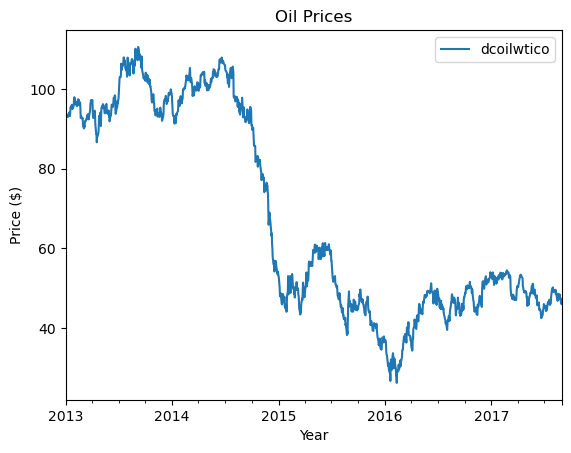

In [12]:
# Time series data oil prices.
dates = pd.date_range(start=oil_df.index.min(), end=oil_df.index.max(), freq='D')
oil_df = oil_df.reindex(dates)
oil_df = oil_df.interpolate(method='time').bfill()
oil_df.index.freq = 'D'
oil_df.plot(title='Oil Prices', xlabel='Year', ylabel='Price ($)');

__Discussion:__

We can also look at transactions history.  The __transactions history__ appears to have spikes just before the end of each year.  This likely corresponds to christmas and other end-of-year holiday celebrations, where people typically spend more money.

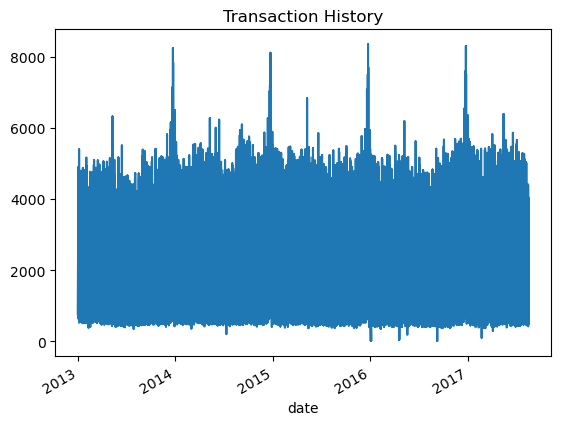

In [13]:
# Transaction history.
transactions_df['transactions'].plot(title='Transaction History');

__Discussion:__

We will now develop a helper function which is responsible for returning the __collection of all sub data frames.__  All data frames are mapped to dates, stores, and departments.  Some stores and departments may share like data (such as oil price).  Others won't because, for example, they may be in a different location where some event has not taken place.  The function takes in the training data set.  It creates a pivot table for each column and then begins adding __oil data, weekend data, holiday data,  wages data, and major events data__ to the data frame.  The pivot table ensures that the dates line up.

In [14]:
# From https://www.kaggle.com/code/sevendev/sales-forecasting-with-lstm

# Data augmentation function.  Combines different soruces of data.
def augment_data(_df, test_dataset=False, columns_to_predict=None, columns=None):
    global oil_df, transactions_df

    # Set pivot values.
    piv_vals = ['sales', 'onpromotion']
    
    if test_dataset:
        piv_vals = ['onpromotion']

    # Create pivot table.
    pivot_df = pd.pivot_table(_df, index=['date'], columns=['store_nbr', 'family'], values=piv_vals, aggfunc='sum')

    # Collect columns
    if test_dataset:
        pivot_df[columns_to_predict] = -1
    else:
        columns = []
        columns_to_predict = []
        for col in pivot_df.columns:
            if col != 'date':
                columns.append(f'{str(col[1])}_{str(col[2])}_{str(col[0])}')
            else:
                columns.append(col)

            if col[0] == 'sales':
                columns_to_predict.append(f'{str(col[1])}_{str(col[2])}_{str(col[0])}')

    # Expand dataframe.
    pivot_df.columns = columns

    # Merge oil data.
    pivot_df = pivot_df.merge(oil_df.add_prefix('oil_'), left_index=True, right_index=True, how='left')

    # Merge Weekend data.
    weekends = pd.DataFrame(index=pd.date_range(start=pivot_df.index.min(), end=pivot_df.index.max(), freq='D'))
    weekdays = weekends.index.weekday
    weekends['weekend'] = ((weekdays == 5) | (weekdays == 6)).astype(int)
    
    pivot_df = pivot_df.merge(weekends, left_index=True, right_index=True, how='left')

    # Merge holiday data. 
    for store_nbr in range(1, len(store_ids + 1)):
        holidays = pd.DataFrame(index=pd.date_range(start=pivot_df.index.min(), end=pivot_df.index.max(), freq='D'))
        holidays['holiday'] = 0
        query = (holidays_df['locale_name'] == stores_df.loc[store_nbr]['city']) & (holidays_df['transferred'] == False)
        holidays.loc[holidays.index.isin(list((holidays_df[query]).index)), 'holiday'] = 1
        pivot_df = pivot_df.merge(holidays, left_index=True, right_index=True, how='left', suffixes=[None, f'_{store_nbr}'])
        
    pivot_df = pivot_df.rename(columns={'holiday': 'holiday_1'})

    # Merge wages data.
    days = pd.DataFrame(index=pd.date_range(start=pivot_df.index.min(), end=pivot_df.index.max(), freq='D'))
    mdays = days.index.day
    days['first'] = (mdays == 1)
    days['last'] = days['first'].shift(periods=-1, freq='D')
    days['last'] = days['last'].fillna(False)
    days['wage_paid'] = ((mdays == 15) | days['last']).astype(int)

    pivot_df = pivot_df.merge(days.drop(columns=['first', 'last']), left_index=True, right_index=True, how='left')

    # Merge major events. There was an earthquake.
    dts = pd.date_range(start=pivot_df.index.min(), end=pivot_df.index.max(), freq='D')
    earthquake = pd.DataFrame(index=dts)
    earthquake['major_event'] = 0
    for event in ['2016-04-16']:
        if (pd.Timestamp(event) in earthquake.index):
            earthquake.loc[event, 'major_event'] = 1
            
    pivot_df = pivot_df.merge(earthquake, left_index=True, right_index=True, how='left')

    # Re-order columns.
    new_order = [col for col in pivot_df.columns if col not in columns_to_predict] + columns_to_predict
    pivot_df = pivot_df[new_order]
    
    return pivot_df.copy(), columns, columns_to_predict

__Discussion:__

The __original training data__ only contained store numbers, departments, sales, and promotion information.

In [21]:
# Output an example of a row in the original data set.
df[(df['store_nbr'] == 2) & (df['family'] == 'AUTOMOTIVE')].loc['2016-07-15']

id                2295579
store_nbr               2
family         AUTOMOTIVE
sales                 4.0
onpromotion             0
Name: 2016-07-15 00:00:00, dtype: object

__Discussion:__

The new __augmented data frame__ contains time series data for each department and store, events data, oil data, and transactions data all collect for the purpose of fitting a complex regression formula.

In [22]:
# Augment data.
transformed_df, columns, columns_to_predict = augment_data(df)
transformed_df.head()

,1_AUTOMOTIVE_onpromotion,1_BABY CARE_onpromotion,1_BEAUTY_onpromotion,1_BEVERAGES_onpromotion,1_BOOKS_onpromotion,1_BREAD/BAKERY_onpromotion,1_CELEBRATION_onpromotion,1_CLEANING_onpromotion,1_DAIRY_onpromotion,1_DELI_onpromotion,...,54_MAGAZINES_sales,54_MEATS_sales,54_PERSONAL CARE_sales,54_PET SUPPLIES_sales,54_PLAYERS AND ELECTRONICS_sales,54_POULTRY_sales,54_PREPARED FOODS_sales,54_PRODUCE_sales,54_SCHOOL AND OFFICE SUPPLIES_sales,54_SEAFOOD_sales
date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,0,0,0,0,0,0,0,0,0,0,...,0.0,0.000,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0
2013-01-02,0,0,0,0,0,0,0,0,0,0,...,0.0,73.771,228.0,0.0,0.0,15.514,61.0,0.0,0.0,3.0
2013-01-03,0,0,0,0,0,0,0,0,0,0,...,0.0,50.257,156.0,0.0,0.0,4.313,1.0,0.0,0.0,2.0
2013-01-04,0,0,0,0,0,0,0,0,0,0,...,0.0,40.223,146.0,0.0,0.0,26.743,38.0,0.0,0.0,2.0
2013-01-05,0,0,0,0,0,0,0,0,0,0,...,0.0,43.431,205.0,0.0,0.0,31.118,32.0,0.0,0.0,1.0


__Discussion:__

We can see that stores and store departments were broken out into their own __columns__ and the extra informational data frames were added to the training data set.

In [23]:
# Now print out training data columns.  Many more.
print(columns[0:50])

['1_AUTOMOTIVE_onpromotion', '1_BABY CARE_onpromotion', '1_BEAUTY_onpromotion', '1_BEVERAGES_onpromotion', '1_BOOKS_onpromotion', '1_BREAD/BAKERY_onpromotion', '1_CELEBRATION_onpromotion', '1_CLEANING_onpromotion', '1_DAIRY_onpromotion', '1_DELI_onpromotion', '1_EGGS_onpromotion', '1_FROZEN FOODS_onpromotion', '1_GROCERY I_onpromotion', '1_GROCERY II_onpromotion', '1_HARDWARE_onpromotion', '1_HOME AND KITCHEN I_onpromotion', '1_HOME AND KITCHEN II_onpromotion', '1_HOME APPLIANCES_onpromotion', '1_HOME CARE_onpromotion', '1_LADIESWEAR_onpromotion', '1_LAWN AND GARDEN_onpromotion', '1_LINGERIE_onpromotion', '1_LIQUOR,WINE,BEER_onpromotion', '1_MAGAZINES_onpromotion', '1_MEATS_onpromotion', '1_PERSONAL CARE_onpromotion', '1_PET SUPPLIES_onpromotion', '1_PLAYERS AND ELECTRONICS_onpromotion', '1_POULTRY_onpromotion', '1_PREPARED FOODS_onpromotion', '1_PRODUCE_onpromotion', '1_SCHOOL AND OFFICE SUPPLIES_onpromotion', '1_SEAFOOD_onpromotion', '2_AUTOMOTIVE_onpromotion', '2_BABY CARE_onpromoti

__Discussion:__

Now we wil check for __nan values.__  We find that there are none.

In [18]:
# Output number of nans.
transformed_df.isna().sum().sum()

0

__Discussion:__

Now we will plot two __sales data__ from two random stores associated with the same department.  Notice that they do in fact follow similar trends including apparent spikes during holidays.

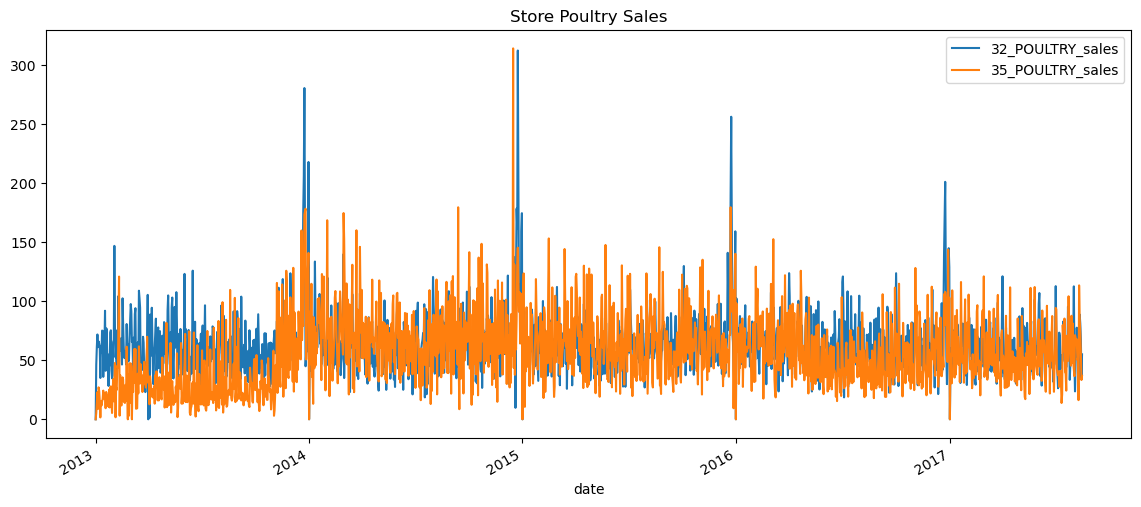

In [19]:
# Output time series data associated with two stores' poultry sales.
transformed_df[['32_POULTRY_sales', '35_POULTRY_sales']].plot(figsize=(14, 6),title='Store Poultry Sales');

__Discussion:__

As we can see below, the training data now contains information on not just __department-wise sales, but also weekends, wages, holidays, and promotions.__

In [20]:
# Output new columns attached to augmented data frame.
transformed_df[['1_AUTOMOTIVE_onpromotion', 'holiday_1', 'wage_paid', 'major_event', 'weekend','1_AUTOMOTIVE_sales']].head(31)

,1_AUTOMOTIVE_onpromotion,holiday_1,wage_paid,major_event,weekend,1_AUTOMOTIVE_sales
date,,,,,,
2013-01-01,0,0,0,0,0,0.0
2013-01-02,0,0,0,0,0,2.0
2013-01-03,0,0,0,0,0,3.0
2013-01-04,0,0,0,0,0,3.0
2013-01-05,0,0,0,0,1,5.0
2013-01-06,0,0,0,0,1,2.0
2013-01-07,0,0,0,0,0,0.0
2013-01-08,0,0,0,0,0,2.0
2013-01-09,0,0,0,0,0,2.0


__Discussion:__

Conclusions regarding modeling can be drawn from the exploratory data analysis.  We can see that we will need a very complex regression model that will need to have extensive __knowledge of past states and its own past outputs.__  This means we need to take advantage of __recurrent neural networks,__ preferably with stored sequences __(LSTM and GRU).__

Further, we will end up with several regression models embedded in the same macro-model.  This is due to the fact that we will need to estimate sales across many different stores and departments, all of which have a different output trend.  However, there may be patterns and similarities between sales (as we observed above) between different stores and departments.  As a result, it will be interesting to experiment with the __'width' and 'depth'__ of different models in order to determine what might be the most efficient.  Further, cross-correlating different stores and departments will also have the effect of __eliminating overfitting__ due to noisy spikes in sales data.  Its unlikely that all stores and departments would experience intermittent and inexplicable spikes, and as a result, a single model trained off all data might observe patterns and reject noise during the training process more effectively than an ensemble of smaller regressor models.

# __Part 2: RNN Training__

After the exploratory data analysis, it was discovered that a vast amount of time series data was needed to make recurrent predictions on future sales data.  This time series data would need to be 'memorized' for trends and patterns that might reveal important information on future sales trajectories.  This meant that __long term short term memory units and gated recurrent units loaded into a sequential model__ would likely perform better than other potential candidate models.

In addition, an ensemble of regressors might end up not only less computationally efficient than a single macro model, but may also be more susceptible to noise and perturbation.  A __single model__ that contains information on all store and department sales data may be less susceptible to noise in the time series data, due to the fact that it will cross-correlate sales from one store to another and tend to ignore anomalies.

Then the question becomes what kind of __architecture__ might we pursue.  Below, we will try a standard model of a reasonable __size and depth.__  Then from there we will modeify the model architecture to build a shallow, but wide network.  After which we will pursue a deep, but thin network architecture.  We will compare all three models in terms of their __mean square error performance.__

The fourth model explored below deviates from the others as it uses __GRUs__ as opposed to LSTMs as the core units of the algorithm.

Finally, the fifth model iterates through many __optimizers and learning rates to explore hyperparameters__ that may end up effecting the data fit.  Finally, the model with __optimal architecture and hyperparameters__ will be retrained and test data will be submitted to kaggle.

__Discussion:__

First, we collect the training data.  Training data is split between __training and validation.__  The end of the training data is used as a validation due to the fact that our recurrent neural network is dependent upon its own outputs.  We will discover how well it fits the validation data and make the assumption that the trend will continue for the test data.

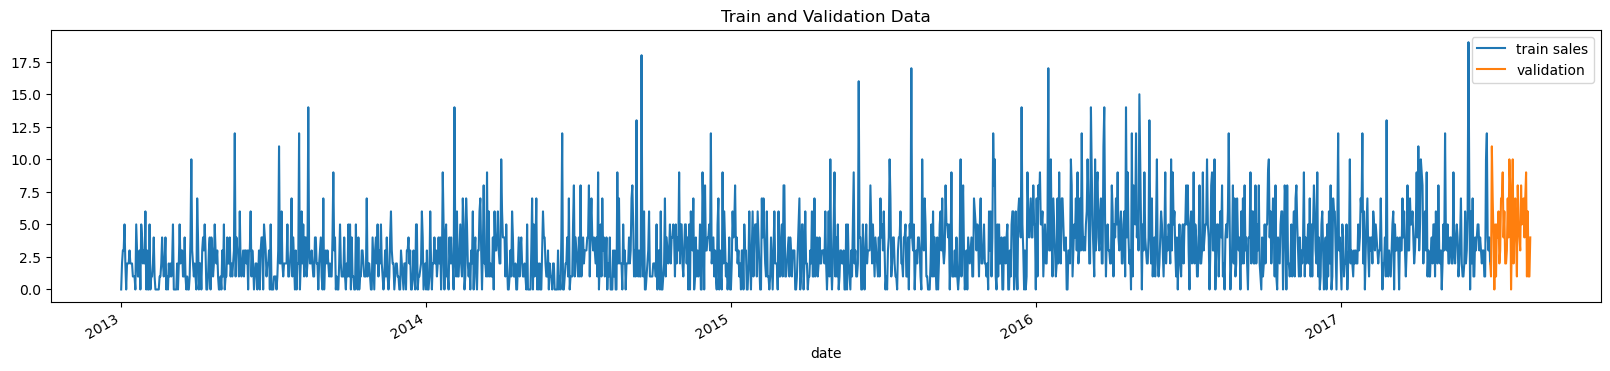

In [21]:
# Identify number of dates to predict.
number_of_dates_to_predict = test.groupby('date').count().count()['id']

# Validation - train split in the form of time series data.
train_data = transformed_df.iloc[:-number_of_dates_to_predict*3]
val_data = transformed_df.iloc[-number_of_dates_to_predict*3-1:]

# Plot time series data split.
ax = train_data['1_AUTOMOTIVE_sales'].rename('train sales').plot(figsize=(20,4), legend=True, title='Train and Validation Data')
val_data['1_AUTOMOTIVE_sales'].rename('validation').plot(ax=ax, legend=True);

__Discussion:__

We create several helper functions.  The first implements a __standard scaler__ which might help the models to fit the data. The second takes a model and __performs predictions__ using a specific set of data (pre data).  It then makes predictions on a set of data after the __pre-data__ and compares it to the __true post data.__  This is rather similar to a validation routine.

In [22]:
# https://www.kaggle.com/code/sevendev/sales-forecasting-with-lstm

def fit_scaler(data):
    # Create standard scaler.
    s = StandardScaler().fit(data)
    return s, s.transform(data)

def pred_data(model, pre_data, post_data, scaler, pred_data_length, cols, dataset_columns):

    # Create scaled pre and post data.
    scaled_pre_data = scaler.transform(pre_data.values)
    scaled_post_data = scaler.transform(post_data.values)
    n_pred_cols = len(cols)

    # Create batches of training data.
    first_eval_batch = scaled_pre_data[-pred_data_length:]
    last_row = scaled_post_data[0].copy()
    last_row[-n_pred_cols:] = -1*np.ones((len(cols),))
    
    first_eval_batch = np.append(first_eval_batch, [last_row], axis=0)
    current_batch = first_eval_batch.reshape((1, pred_data_length+1, total_columns))

    preds = []

    # Iterate through batches and perform predictions with input model.
    for i in range(len(scaled_post_data)):
        last_row = scaled_post_data[i].copy()
        current_pred = model.predict(current_batch, verbose=0)
        last_row[-n_pred_cols:] = current_pred[0]
        preds.append(last_row) 
        current_batch = np.array([np.append(current_batch[0, 1:], [last_row], axis=0)])

    # Return predictions after inverting scaler action.
    predictions_df = pd.DataFrame(scaler.inverse_transform(np.array(preds)), columns=dataset_columns)
    predictions_df.index = post_data.index
    
    return predictions_df

__Discussion:__

We now create the standard scaler, training data, validation data, and a couple other __important variables.__  The learning rate is set to a very low value until the fifth model during which it is evaluated as a hyper parameter.

In [23]:
# Create scaler and scaled training data.
scaler, scaled_train = fit_scaler(train_data)

# Identify sample length.
sample_length = 9*number_of_dates_to_predict

# learning rate init.
lr = 0.000075

# column for plotting and performance observing purposes.
c = '32_PLAYERS AND ELECTRONICS_sales'

# Toggles whether to turn up or down number of epochs.
full_sim = 10

# Number of columns for prediction rather than information.
n_columns_to_predict = len(columns_to_predict)

# Total columns.
total_columns = scaled_train.shape[1]

# Create training input data.
inputs = []
outputs = []

for row_index in range(scaled_train.shape[0] - (sample_length + 1)):
    input = scaled_train[row_index:row_index + sample_length + 1].copy()
    output = scaled_train[row_index + sample_length, -len(columns_to_predict):].copy()
    input[sample_length, -len(columns_to_predict):] = -1*np.ones((len(columns_to_predict),))
    inputs.append(input)
    outputs.append(output)
    
x_data = np.array(inputs)
y_data = np.array(outputs)

# Scale and then create validation input data.
scaled_val = scaler.transform(val_data)

inputs = []
outputs = []

for row_index in range(scaled_val.shape[0] - (16 + 1)):
    input = scaled_val[row_index:row_index + 16 + 1].copy()
    output = scaled_val[row_index + 16, -len(columns_to_predict):].copy()
    input[16, -len(columns_to_predict):] = -1*np.ones((len(columns_to_predict),))
    inputs.append(input)
    outputs.append(output)
    
x_val_data = np.array(inputs)
y_val_data = np.array(outputs)

__Discussion:__

The first model contains our __standard architecture.__  It requires many epochs to train well, so we set the epochs to 200.  The model contains __two 100 unit LSTM layers and two dense layers.__  It uses __Adam optimizer and our default learning rate__ along with __mean squared error__ as our loss criterion.  This makes sense given we are solving a regression problem.

After developing the model, we train the first model.  Unfortunately, despite owning a GPU and following many online sources, I was unable to implement CUDA accelerated training.

Finally, we plot the training and validation mean squared error curves in order to identify __how many epochs might be most effective__ for creating a well-formed and generalizable model avoiding both a biased fit and an overfit given its own architectural limitations on accuracy, of course.

In addition, using our pred_data helper function, we make predictions on the validation data and plot our model's fit.  This allows us to __visually observe its performance.__  Would we trust it enough to make financial decisions based on sales data?  I guess it depends on how lucky we're feeling.

The optimal number of epochs found for model 1 was 94.  There were some places where it dipped lower, but the surrounding epoch region was generally unstabled.

__Model 1 Optimal Epochs: 94.__

In [24]:
# Instantiate epochs.
epochs = 20*full_sim

# Generate and compile model.
model_1 = Sequential([
    Input(shape=(sample_length, total_columns)),
    LSTM(100, return_sequences=True),
    LSTM(100),
    Dense(50, activation='relu'),
    Dense(50, activation='relu'),
    Dense(n_columns_to_predict)])

model_1.compile(optimizer=Adam(learning_rate=lr), loss = MeanSquaredError, metrics = ['mse'])
model_1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 144, 100)       │     1,488,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 100)            │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1782)           │        90,882 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,667,682 (6.36 MB)

 Trainable params: 1,667,682 (6.36 MB)

 Non-trainable params: 0 (0.00 B)

In [25]:
# Train model.
hist1 = model_1.fit(x=x_data,y=y_data,epochs=epochs,validation_data=(x_val_data, y_val_data),verbose=True)

Epoch 1/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 13s 205ms/step - loss: 1.0045 - mse: 1.0045 - val_loss: 2.4794 - val_mse: 2.4794
Epoch 2/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 9s 192ms/step - loss: 0.9496 - mse: 0.9496 - val_loss: 2.3732 - val_mse: 2.3732
Epoch 3/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 9s 197ms/step - loss: 0.8904 - mse: 0.8904 - val_loss: 2.2613 - val_mse: 2.2613
Epoch 4/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 9s 194ms/step - loss: 0.8208 - mse: 0.8208 - val_loss: 2.2027 - val_mse: 2.2027
Epoch 5/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 9s 188ms/step - loss: 0.7861 - mse: 0.7861 - val_loss: 2.1354 - val_mse: 2.1354
Epoch 6/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 9s 193ms/step - loss: 0.7459 - mse: 0.7459 - val_loss: 2.1102 - val_mse: 2.1102
Epoch 7/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 9s 189ms/step - loss: 0.7376 - mse: 0.7376 - val_loss: 2.1089 - val_mse: 2.1089
Epoch 8/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 9s 192ms/step - loss: 0.7485 - mse: 0.7485 - val_loss: 2.1007 - val_mse: 2.1007
Epoch 9/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 9s 192ms

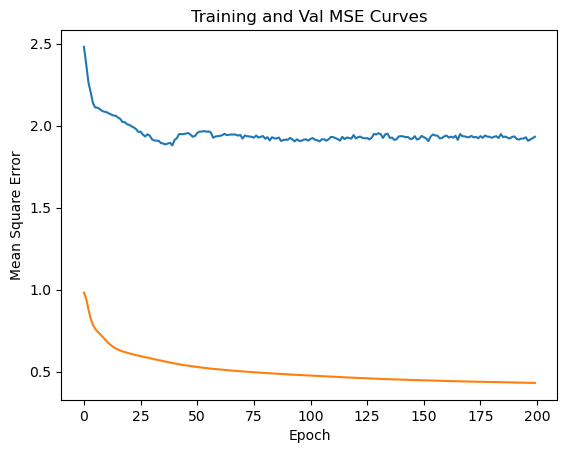

In [26]:
# Plot training and validation MSE curves.
y1 = hist1.history['val_mse']
y2 = hist1.history['mse']
x = range(len(hist1.history['val_mse']))
plt.plot(x,y1,y2)
plt.title("Training and Val MSE Curves")
plt.xlabel("Epoch")
plt.ylabel("Mean Square Error")

plt.show()

In [27]:
# Make predictions using current model.
predictions = pred_data(model=model_1,pre_data=train_data,post_data=val_data,scaler=scaler,pred_data_length=sample_length,
    cols=columns_to_predict,dataset_columns=val_data.columns)

predictions.head()

,1_AUTOMOTIVE_onpromotion,1_BABY CARE_onpromotion,1_BEAUTY_onpromotion,1_BEVERAGES_onpromotion,1_BOOKS_onpromotion,1_BREAD/BAKERY_onpromotion,1_CELEBRATION_onpromotion,1_CLEANING_onpromotion,1_DAIRY_onpromotion,1_DELI_onpromotion,...,54_MAGAZINES_sales,54_MEATS_sales,54_PERSONAL CARE_sales,54_PET SUPPLIES_sales,54_PLAYERS AND ELECTRONICS_sales,54_POULTRY_sales,54_PREPARED FOODS_sales,54_PRODUCE_sales,54_SCHOOL AND OFFICE SUPPLIES_sales,54_SEAFOOD_sales
date,,,,,,,,,,,,,,,,,,,,,
2017-06-28,0.0,0.0,1.0,26.0,0.0,6.0,0.0,43.0,23.0,1.0,...,0.886677,55.549320,169.340184,0.083602,2.518427,60.653935,87.450058,593.398683,0.080477,2.609795
2017-06-29,0.0,0.0,1.0,26.0,0.0,6.0,0.0,42.0,23.0,1.0,...,0.912486,56.313226,175.128440,0.085059,2.541989,62.750256,84.694914,564.404757,0.118918,2.541357
2017-06-30,0.0,0.0,1.0,30.0,0.0,9.0,0.0,48.0,23.0,53.0,...,0.989892,57.334824,171.520708,0.071760,2.503308,66.013146,85.788325,553.899122,-0.119152,2.348829
2017-07-01,0.0,0.0,1.0,27.0,0.0,6.0,0.0,39.0,20.0,0.0,...,1.198939,59.436791,197.157640,0.098885,3.156230,75.262511,87.596388,654.565302,-0.081997,2.247262
2017-07-02,0.0,0.0,1.0,25.0,0.0,6.0,0.0,30.0,19.0,2.0,...,1.356958,66.014618,257.661737,0.177124,4.317069,85.656565,98.679912,781.413389,0.200937,2.637621


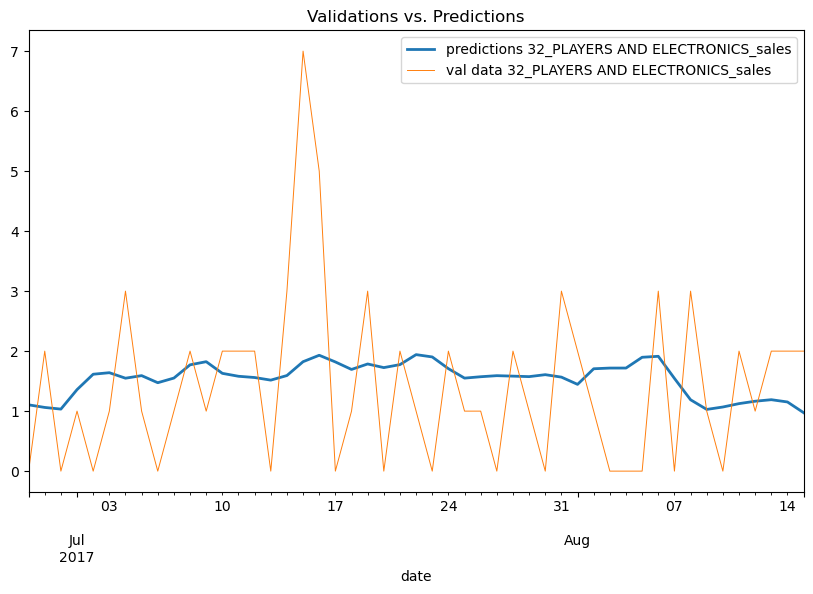

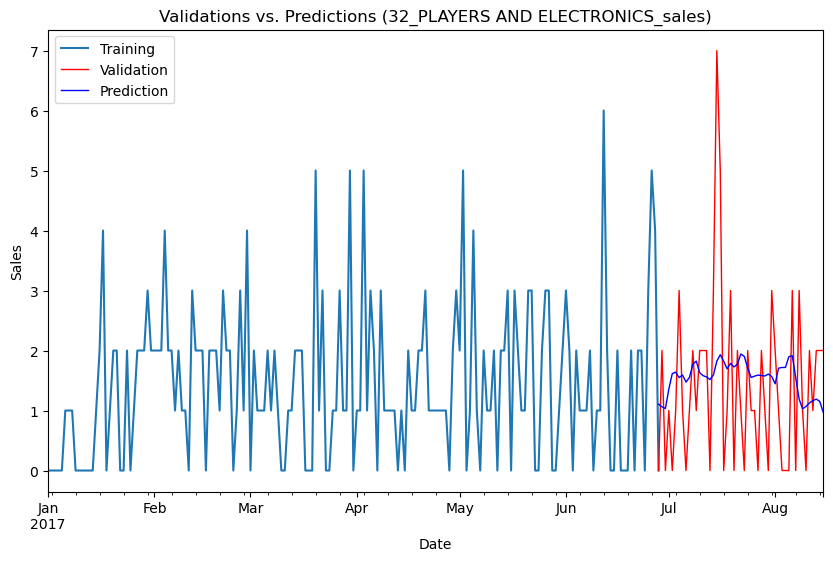

In [28]:
# Plot snapshot of performance.
ax = predictions[c].rename(f'predictions {c}').plot(figsize=(10,6), lw=2, title='Validations vs. Predictions', legend=True)
val_data[c].rename(f'val data {c}').plot(ax=ax, lw=0.7, legend=True)
plt.show()

# Plot performance against training data.
ax = train_data[[c]].loc['2017':].plot(figsize=(10,6), title=f'Validations vs. Predictions ({c})')
val_data[[c]].loc['2017':].plot(ax=ax, lw=1, color='r')
(predictions[[c]].loc['2017':]).plot(ax=ax, lw=1, color='b')
ax.legend(['Training','Validation','Prediction'])
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
plt.show()

__Discussion:__

We will now go through our same analysis process using a second model.  The second model is much wider than the first with __LSTM units of size 500 and dense layers of size 250,__ but contained the __same layered architecture__ as the first.  It was found that training takes along time (especially because I can't use my GPU) and furthermore, the model's validation MSE seems to level out around epoch 20.  As a result, training was only run for 50 epochs.  __All other parameters remained the same for this model.__

After training the model, we plot its training and validation curves to once again determine what the optimal number of training epochs might be in order to avoid an overfit.  We also plot some results for predictions against validation data and compare it side by side with prior time series training data.

The large LSTM model performed very well, but is very heavy with 10m parameters and takes a very long time to train.  It will compete with the GRUs model for first place.  It also didn't appear finished training.  I would place its optimal epochs at 60.

__Model 2 Optimal Epochs: 60.__

In [29]:
# Instantiate epochs.
epochs = 5*full_sim

# Generate and compile model.
model_2 = Sequential([
    Input(shape=(sample_length, total_columns)),
    LSTM(500, return_sequences=True),
    LSTM(500),
    Dense(250, activation='relu'),
    Dense(250, activation='relu'),
    Dense(n_columns_to_predict)])

model_2.compile(optimizer=Adam(learning_rate=lr), loss = MeanSquaredError, metrics = ['mse'])
model_2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 144, 500)       │     8,244,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 500)            │     2,002,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 250)            │       125,250 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 250)            │        62,750 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1782)           │       447,282 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,881,282 (41.51 MB)

 Trainable params: 10,881,282 (41.51 MB)

 Non-trainable params: 0 (0.00 B)

In [30]:
# Train model.
hist2 = model_2.fit(x=x_data,y=y_data,epochs=epochs,validation_data=(x_val_data, y_val_data),verbose=True)

Epoch 1/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 77s 2s/step - loss: 0.9713 - mse: 0.9713 - val_loss: 2.3062 - val_mse: 2.3062
Epoch 2/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 75s 2s/step - loss: 0.8580 - mse: 0.8580 - val_loss: 2.1164 - val_mse: 2.1164
Epoch 3/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 76s 2s/step - loss: 0.7498 - mse: 0.7498 - val_loss: 2.0874 - val_mse: 2.0874
Epoch 4/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 76s 2s/step - loss: 0.7017 - mse: 0.7017 - val_loss: 2.0373 - val_mse: 2.0373
Epoch 5/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 79s 2s/step - loss: 0.6569 - mse: 0.6569 - val_loss: 1.9964 - val_mse: 1.9964
Epoch 6/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 77s 2s/step - loss: 0.6418 - mse: 0.6418 - val_loss: 1.9413 - val_mse: 1.9413
Epoch 7/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 78s 2s/step - loss: 0.5955 - mse: 0.5955 - val_loss: 1.9280 - val_mse: 1.9280
Epoch 8/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 78s 2s/step - loss: 0.5843 - mse: 0.5843 - val_loss: 1.9241 - val_mse: 1.9241
Epoch 9/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 75s 2s/step - loss: 0.5742 - mse: 

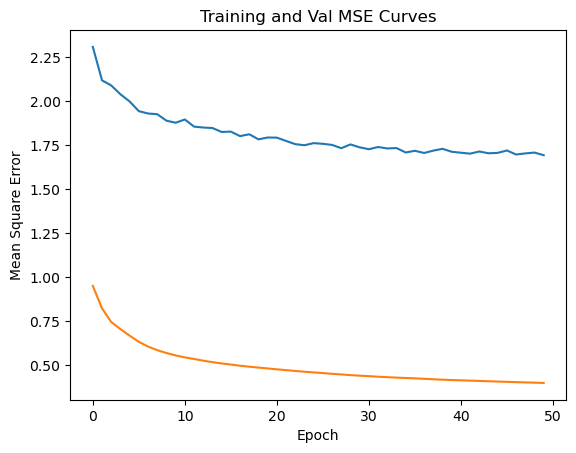

In [31]:
# Plot training and validation MSE curves.
y1 = hist2.history['val_mse']
y2 = hist2.history['mse']
x = range(len(hist2.history['val_mse']))
plt.plot(x,y1,y2)
plt.title("Training and Val MSE Curves")
plt.xlabel("Epoch")
plt.ylabel("Mean Square Error")

plt.show()

In [32]:
# Make predictions using current model.
predictions = pred_data(model=model_2,pre_data=train_data,post_data=val_data,scaler=scaler,pred_data_length=sample_length,
    cols=columns_to_predict,dataset_columns=val_data.columns)

predictions.head()

,1_AUTOMOTIVE_onpromotion,1_BABY CARE_onpromotion,1_BEAUTY_onpromotion,1_BEVERAGES_onpromotion,1_BOOKS_onpromotion,1_BREAD/BAKERY_onpromotion,1_CELEBRATION_onpromotion,1_CLEANING_onpromotion,1_DAIRY_onpromotion,1_DELI_onpromotion,...,54_MAGAZINES_sales,54_MEATS_sales,54_PERSONAL CARE_sales,54_PET SUPPLIES_sales,54_PLAYERS AND ELECTRONICS_sales,54_POULTRY_sales,54_PREPARED FOODS_sales,54_PRODUCE_sales,54_SCHOOL AND OFFICE SUPPLIES_sales,54_SEAFOOD_sales
date,,,,,,,,,,,,,,,,,,,,,
2017-06-28,0.0,0.0,1.0,26.0,0.0,6.0,0.0,43.0,23.0,1.0,...,0.454812,51.873846,112.801468,0.057053,1.817901,55.298376,78.365425,527.054305,0.659371,2.180709
2017-06-29,0.0,0.0,1.0,26.0,0.0,6.0,0.0,42.0,23.0,1.0,...,0.480539,51.659087,113.917852,0.032966,1.840654,56.332467,78.274852,494.679610,0.686476,1.984560
2017-06-30,0.0,0.0,1.0,30.0,0.0,9.0,0.0,48.0,23.0,53.0,...,0.645815,52.919168,125.367840,0.039852,1.937604,58.728276,81.891461,517.560620,0.749924,1.863610
2017-07-01,0.0,0.0,1.0,27.0,0.0,6.0,0.0,39.0,20.0,0.0,...,0.977644,55.278111,156.445664,0.013111,2.392939,68.494525,82.509335,609.911321,0.612944,1.466953
2017-07-02,0.0,0.0,1.0,25.0,0.0,6.0,0.0,30.0,19.0,2.0,...,1.149684,60.489939,212.973147,0.045772,3.117984,76.586562,94.397809,713.909829,0.910107,1.737279


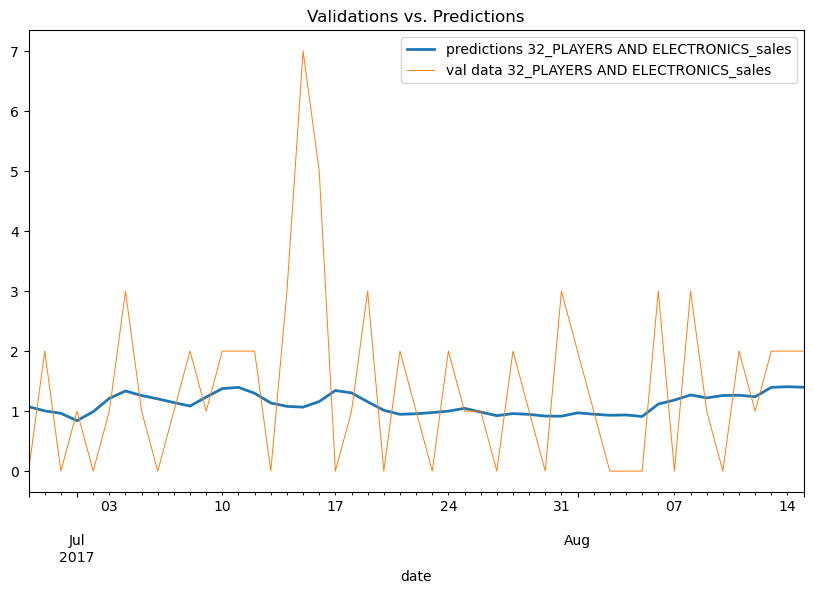

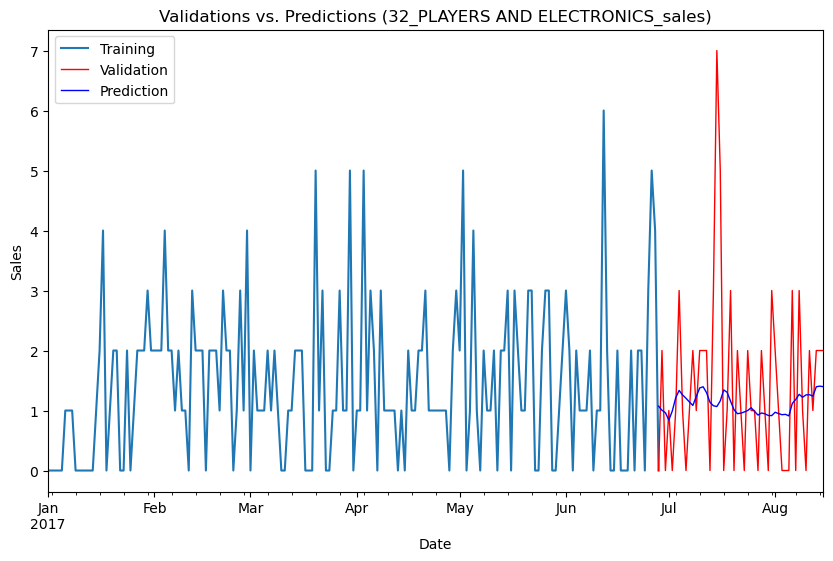

In [33]:
# Plot snapshot of performance.
ax = predictions[c].rename(f'predictions {c}').plot(figsize=(10,6), lw=2, title='Validations vs. Predictions', legend=True)
val_data[c].rename(f'val data {c}').plot(ax=ax, lw=0.7, legend=True)
plt.show()

# Plot performance against training data.
ax = train_data[[c]].loc['2017':].plot(figsize=(10,6), title=f'Validations vs. Predictions ({c})')
val_data[[c]].loc['2017':].plot(ax=ax, lw=1, color='r')
(predictions[[c]].loc['2017':]).plot(ax=ax, lw=1, color='b')
ax.legend(['Training','Validation','Prediction'])
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
plt.show()

__Discussion:__

We will now go through our same analysis process using a third model.  The third model had LSTM units and dense layers of the same size as the first model, but __twice as many LSTM layers__ (4).  The third model's architecture was __taller__ rather than wider than the first.  I assumed that the taller model would require __more epochs__ to train and was excited to see whether or not this model would greatly outperform the first given that it ought to be able to construct higher level objects off of its own outputs and the time series training data.

As a result, 300 epochs were used to train this model, but all other parameters remained the same.  After training, we once again look at the training and validation MSE curves to determine an optimal number of epochs.  Finally, we plot some prediction results against validation data.

The deep model, with twice as many LSTM layers as the standard model, did not live up to expectations, unfortunately.  Its validation MSE failed to break 2.0, unlike the previous two models.  That being said, it did reach its minimum very quickly, after only 25 epochs taking 13 seconds each.

__Model 3 Optimal Epochs: 25.__

In [34]:
# Instantiate epochs.
epochs = 30*full_sim

# Generate and compile model.
model_3 = Sequential([
    Input(shape=(sample_length, total_columns)),
    LSTM(100, return_sequences=True),
    LSTM(100,return_sequences=True),
    LSTM(100,return_sequences=True),
    LSTM(100),
    Dense(50, activation='relu'),
    Dense(50, activation='relu'),
    Dense(n_columns_to_predict)])

model_3.compile(optimizer=Adam(learning_rate=lr), loss = MeanSquaredError, metrics = ['mse'])
model_3.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 144, 100)       │     1,488,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 144, 100)       │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 144, 100)       │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 100)            │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1782)           │        90,882 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,828,482 (6.98 MB)

 Trainable params: 1,828,482 (6.98 MB)

 Non-trainable params: 0 (0.00 B)

In [35]:
# Train model.
hist3 = model_3.fit(x=x_data,y=y_data,epochs=epochs,validation_data=(x_val_data, y_val_data),verbose=True)

Epoch 1/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 18s 269ms/step - loss: 0.9649 - mse: 0.9649 - val_loss: 2.4729 - val_mse: 2.4729
Epoch 2/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 12s 258ms/step - loss: 0.9481 - mse: 0.9481 - val_loss: 2.3642 - val_mse: 2.3642
Epoch 3/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 13s 282ms/step - loss: 0.8815 - mse: 0.8815 - val_loss: 2.2571 - val_mse: 2.2571
Epoch 4/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 14s 285ms/step - loss: 0.8484 - mse: 0.8484 - val_loss: 2.2054 - val_mse: 2.2054
Epoch 5/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 13s 267ms/step - loss: 0.8203 - mse: 0.8203 - val_loss: 2.1639 - val_mse: 2.1639
Epoch 6/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 13s 272ms/step - loss: 0.7922 - mse: 0.7922 - val_loss: 2.1488 - val_mse: 2.1488
Epoch 7/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 13s 270ms/step - loss: 0.8157 - mse: 0.8157 - val_loss: 2.1431 - val_mse: 2.1431
Epoch 8/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 13s 277ms/step - loss: 0.7909 - mse: 0.7909 - val_loss: 2.1325 - val_mse: 2.1325
Epoch 9/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 1

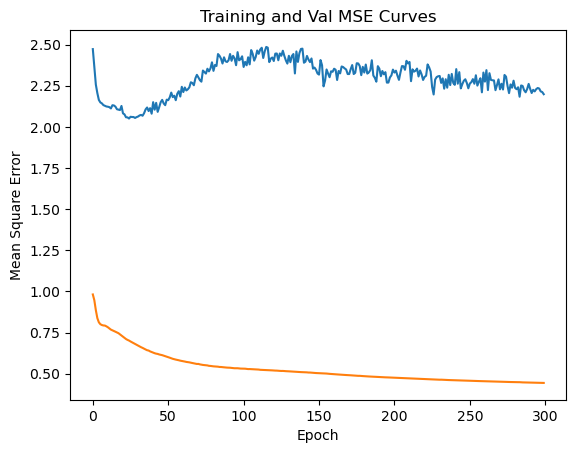

In [36]:
# Plot training and validation MSE curves.
y1 = hist3.history['val_mse']
y2 = hist3.history['mse']
x = range(len(hist3.history['val_mse']))
plt.plot(x,y1,y2)
plt.title("Training and Val MSE Curves")
plt.xlabel("Epoch")
plt.ylabel("Mean Square Error")

plt.show()

In [37]:
# Make predictions using current model.
predictions = pred_data(model=model_3,pre_data=train_data,post_data=val_data,scaler=scaler,pred_data_length=sample_length,
    cols=columns_to_predict,dataset_columns=val_data.columns)

predictions.head()

,1_AUTOMOTIVE_onpromotion,1_BABY CARE_onpromotion,1_BEAUTY_onpromotion,1_BEVERAGES_onpromotion,1_BOOKS_onpromotion,1_BREAD/BAKERY_onpromotion,1_CELEBRATION_onpromotion,1_CLEANING_onpromotion,1_DAIRY_onpromotion,1_DELI_onpromotion,...,54_MAGAZINES_sales,54_MEATS_sales,54_PERSONAL CARE_sales,54_PET SUPPLIES_sales,54_PLAYERS AND ELECTRONICS_sales,54_POULTRY_sales,54_PREPARED FOODS_sales,54_PRODUCE_sales,54_SCHOOL AND OFFICE SUPPLIES_sales,54_SEAFOOD_sales
date,,,,,,,,,,,,,,,,,,,,,
2017-06-28,0.0,0.0,1.0,26.0,0.0,6.0,0.0,43.0,23.0,1.0,...,0.889890,52.270132,130.174329,0.052228,2.060942,52.976292,80.722470,523.997758,-0.024938,2.172025
2017-06-29,0.0,0.0,1.0,26.0,0.0,6.0,0.0,42.0,23.0,1.0,...,0.979752,51.106410,125.416758,0.040997,2.177007,58.888301,76.806220,516.883224,-0.009761,1.974803
2017-06-30,0.0,0.0,1.0,30.0,0.0,9.0,0.0,48.0,23.0,53.0,...,1.193647,54.374558,157.394550,0.059256,3.014909,73.738653,81.142465,600.543997,0.047019,1.856681
2017-07-01,0.0,0.0,1.0,27.0,0.0,6.0,0.0,39.0,20.0,0.0,...,1.517934,63.844980,245.665606,0.100635,4.571989,88.376576,103.047619,808.382873,1.328029,2.327359
2017-07-02,0.0,0.0,1.0,25.0,0.0,6.0,0.0,30.0,19.0,2.0,...,1.541503,71.428285,313.063202,0.093825,5.348573,86.991298,119.801348,874.302767,2.176446,2.961826


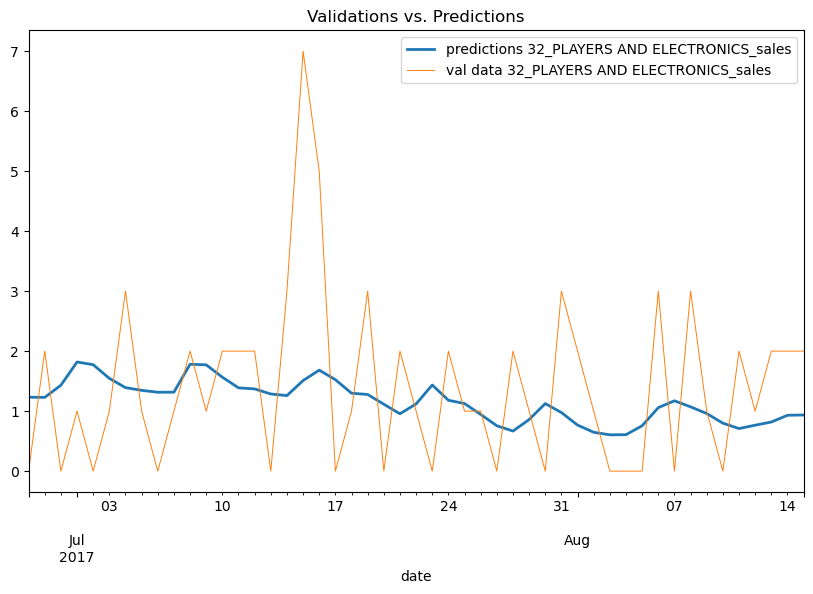

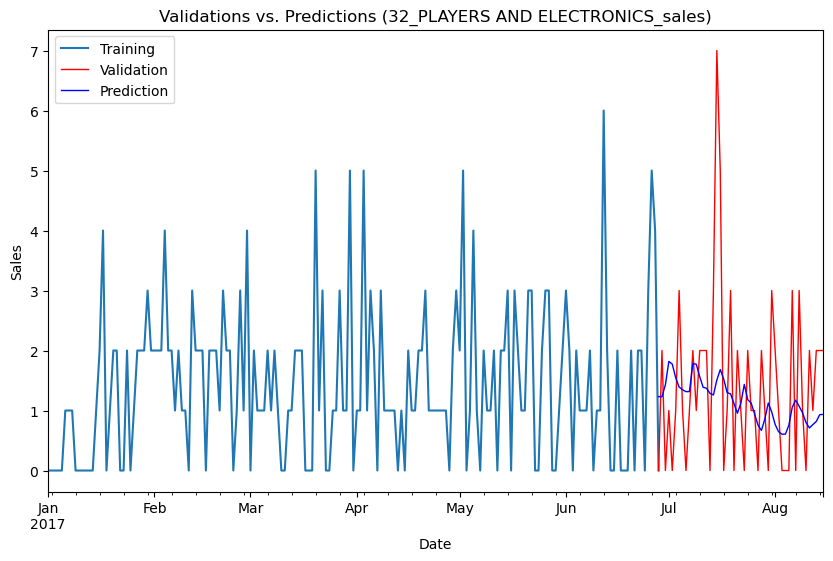

In [38]:
# Plot snapshot of performance.
ax = predictions[c].rename(f'predictions {c}').plot(figsize=(10,6), lw=2, title='Validations vs. Predictions', legend=True)
val_data[c].rename(f'val data {c}').plot(ax=ax, lw=0.7, legend=True)
plt.show()

# Plot performance against training data.
ax = train_data[[c]].loc['2017':].plot(figsize=(10,6), title=f'Validations vs. Predictions ({c})')
val_data[[c]].loc['2017':].plot(ax=ax, lw=1, color='r')
(predictions[[c]].loc['2017':]).plot(ax=ax, lw=1, color='b')
ax.legend(['Training','Validation','Prediction'])
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
plt.show()

__Discussion:__

We will now test __GRUs__ to see if they outperform LSTMs as the fundamental unit within our RNN algorithm.  The model is constructed with the __same parameters__ as before, the __same number of units and overall architecture__ is utilized.  Further, the same number of __epochs (200)__ as the first model are run in order to observe convergence time to a good unbiased and non-overfitting model. The only difference is that instead of two LSTM layers of size 100, this model uses two GRU layers of size 100.

After training, we once again look at the validation and training MSE curves to look for an optimal number of training epochs.  Finally, we output its predictions against some validation data to look at performance.

The GRUs model performed very similarly to the second 'wide' model with lots of LSTMs.  This is impressive considering it is far lighter and quicker to train.  It also didn't seem like it was finished training even after 200 epochs.  Would recommend 220 epochs considering this looks like it will be our candidate model. 

__Model 3 Optimal Epochs: 220.__

In [39]:
# Instantiate epochs.
epochs = 20*full_sim

# Generate and compile model.
model_4 = Sequential([
    Input(shape=(sample_length, total_columns)),
    GRU(units=100, return_sequences=True),
    GRU(units=100),
    Dense(50, activation='relu'),
    Dense(50, activation='relu'),
    Dense(n_columns_to_predict)])

model_4.compile(optimizer=Adam(learning_rate=lr), loss = MeanSquaredError, metrics = ['mse'])
model_4.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 144, 100)       │     1,116,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 100)            │        60,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1782)           │        90,882 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,275,982 (4.87 MB)

 Trainable params: 1,275,982 (4.87 MB)

 Non-trainable params: 0 (0.00 B)

In [40]:
# Train model.
hist4 = model_4.fit(x=x_data,y=y_data,epochs=epochs,validation_data=(x_val_data, y_val_data),verbose=True)

Epoch 1/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 13s 194ms/step - loss: 0.9594 - mse: 0.9594 - val_loss: 2.4776 - val_mse: 2.4776
Epoch 2/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 8s 173ms/step - loss: 0.9801 - mse: 0.9801 - val_loss: 2.3630 - val_mse: 2.3630
Epoch 3/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 8s 173ms/step - loss: 0.8945 - mse: 0.8945 - val_loss: 2.2386 - val_mse: 2.2386
Epoch 4/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 8s 168ms/step - loss: 0.8054 - mse: 0.8054 - val_loss: 2.1600 - val_mse: 2.1600
Epoch 5/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 8s 177ms/step - loss: 0.7779 - mse: 0.7779 - val_loss: 2.1293 - val_mse: 2.1293
Epoch 6/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 8s 175ms/step - loss: 0.7758 - mse: 0.7758 - val_loss: 2.1147 - val_mse: 2.1147
Epoch 7/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 9s 188ms/step - loss: 0.6958 - mse: 0.6958 - val_loss: 2.0999 - val_mse: 2.0999
Epoch 8/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 8s 177ms/step - loss: 0.7254 - mse: 0.7254 - val_loss: 2.0940 - val_mse: 2.0940
Epoch 9/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 8s 178ms

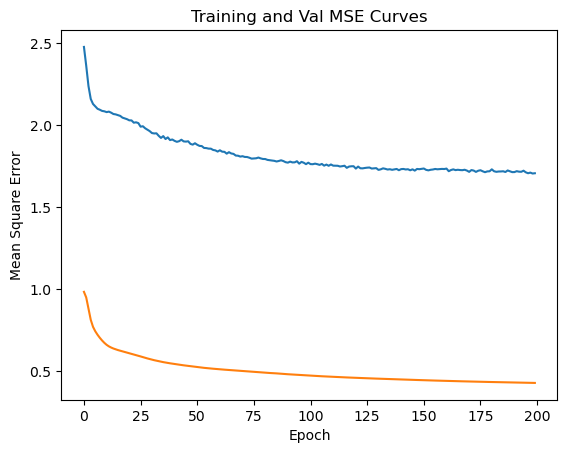

In [41]:
# Plot training and validation MSE curves.
y1 = hist4.history['val_mse']
y2 = hist4.history['mse']
x = range(len(hist4.history['val_mse']))
plt.plot(x,y1,y2)
plt.title("Training and Val MSE Curves")
plt.xlabel("Epoch")
plt.ylabel("Mean Square Error")

plt.show()

In [42]:
# Make predictions using current model.
predictions = pred_data(model=model_4,pre_data=train_data,post_data=val_data,scaler=scaler,pred_data_length=sample_length,
    cols=columns_to_predict,dataset_columns=val_data.columns)

predictions.head()

,1_AUTOMOTIVE_onpromotion,1_BABY CARE_onpromotion,1_BEAUTY_onpromotion,1_BEVERAGES_onpromotion,1_BOOKS_onpromotion,1_BREAD/BAKERY_onpromotion,1_CELEBRATION_onpromotion,1_CLEANING_onpromotion,1_DAIRY_onpromotion,1_DELI_onpromotion,...,54_MAGAZINES_sales,54_MEATS_sales,54_PERSONAL CARE_sales,54_PET SUPPLIES_sales,54_PLAYERS AND ELECTRONICS_sales,54_POULTRY_sales,54_PREPARED FOODS_sales,54_PRODUCE_sales,54_SCHOOL AND OFFICE SUPPLIES_sales,54_SEAFOOD_sales
date,,,,,,,,,,,,,,,,,,,,,
2017-06-28,0.0,0.0,1.0,26.0,0.0,6.0,0.0,43.0,23.0,1.0,...,0.922649,49.205513,123.984404,0.141827,2.447497,46.034673,83.215372,526.463487,-0.002489,1.760017
2017-06-29,0.0,0.0,1.0,26.0,0.0,6.0,0.0,42.0,23.0,1.0,...,1.281182,53.727970,152.856499,0.199249,3.216436,50.279801,88.059909,573.401209,1.571888,1.614359
2017-06-30,0.0,0.0,1.0,30.0,0.0,9.0,0.0,48.0,23.0,53.0,...,1.455435,56.565030,156.496806,0.162392,3.587686,54.701322,88.779392,626.630079,3.663419,1.810015
2017-07-01,0.0,0.0,1.0,27.0,0.0,6.0,0.0,39.0,20.0,0.0,...,2.006102,57.895340,229.709440,0.169558,5.177878,68.535227,89.669921,755.587717,5.823735,2.692974
2017-07-02,0.0,0.0,1.0,25.0,0.0,6.0,0.0,30.0,19.0,2.0,...,2.103546,56.093288,251.077324,0.184267,5.403143,70.106241,98.391487,749.978825,7.948952,3.141083


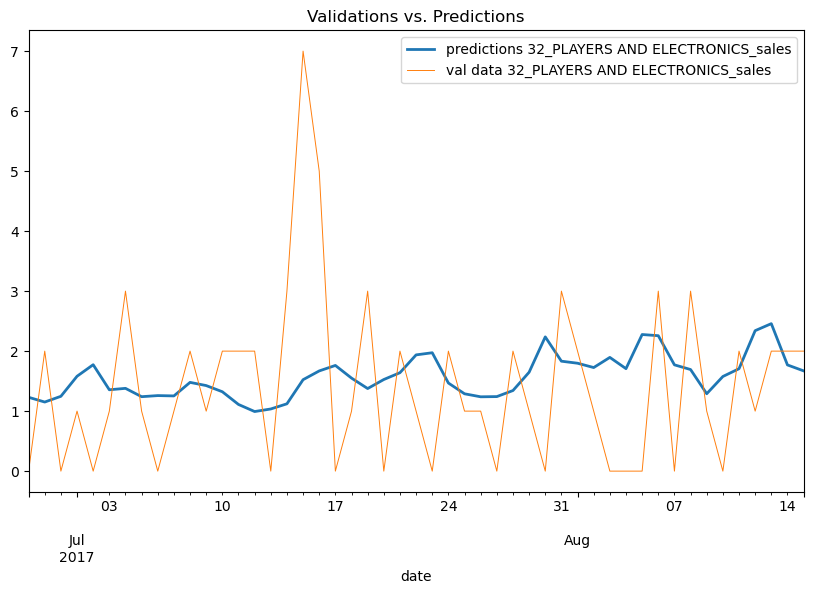

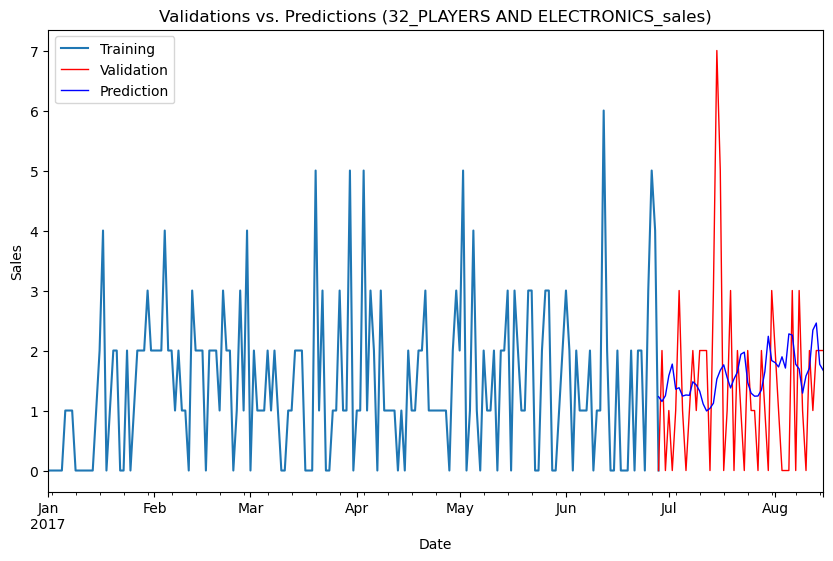

In [43]:
# Plot snapshot of performance.
ax = predictions[c].rename(f'predictions {c}').plot(figsize=(10,6), lw=2, title='Validations vs. Predictions', legend=True)
val_data[c].rename(f'val data {c}').plot(ax=ax, lw=0.7, legend=True)
plt.show()

# Plot performance against training data.
ax = train_data[[c]].loc['2017':].plot(figsize=(10,6), title=f'Validations vs. Predictions ({c})')
val_data[[c]].loc['2017':].plot(ax=ax, lw=1, color='r')
(predictions[[c]].loc['2017':]).plot(ax=ax, lw=1, color='b')
ax.legend(['Training','Validation','Prediction'])
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
plt.show()

__Discussion:__

Up to this point, we have evaluated different model architectures.  We have studied the effects of applying different numbers of training epochs to each model in order to optimize for generalizability and __reduce the likelihood of an overfit while still maintaining high accuracy.__

Now we will perform __hyperparameter tuning.__  In particular, we will iterate through different __optimizers and learning rates__ to determine whether or not these optimizers can actually get the models to acheive a higher degree of accuracy.

We will walk through four different optimizers and five different initial learning rates.  Some of these optimizers automatically adapt the learning rate, but the initial learning rate is still important.

We will then __combine the best model architecture from above and the best optimizer/intial learning rate from below__ to produce our final model.

Only 20 epochs were used per learning rate and optimizer combination.  This was due to the fact that I couldn't get my GPU going with tensorflow.  It would take far too long to turn 200 x 4 x 5 epochs... As a result, the methodology is not perfect, but we will still go with the best initial learning rate and optimizer identified if anything for experimentation's sake.

In [44]:
# Identify iteration learning rates for hyper parameter sweep.
learning_rates = [0.00001, 0.0001, 0.001, 0.01, 0.1]

# Instantiate epochs.
epochs = 2*full_sim

# Need to store histories to identify best hyper parameters.
hists = []

for n in learning_rates:

    # Identify iteration optimizers for hyper parameter sweep.
    opts = [keras.optimizers.Adam(learning_rate=n),keras.optimizers.RMSprop(learning_rate=n),keras.optimizers.Adagrad(learning_rate=n),
            keras.optimizers.SGD(learning_rate=n)]

    # Loop through initial learning rates and optimizers.
    for k in opts:
        # Generate and compile model.
        model_5 = Sequential([
            Input(shape=(sample_length, total_columns)),
            LSTM(100, return_sequences = True),
            LSTM(100),
            Dense(50, activation='relu'),
            Dense(50, activation='relu'),
            Dense(n_columns_to_predict)])

        # Train model.
        model_5.compile(optimizer=k, loss = MeanSquaredError, metrics = ['mse'])
        history = model_5.fit(x=x_data,y=y_data,epochs=epochs,validation_data=(x_val_data, y_val_data),verbose = 0)
        hists.append(history)

In [45]:
# Initialize variables.
ind = -1
minVal = 1000000
bestLR = 0
bestOpt = opts[0]

# Loop through learning rates and optimizers.
for n in learning_rates:
    for k in opts:
        ind += 1

        # Peel off histories.
        hist = hists[ind]

        # Extract minimum validation MSE.
        for val in hist.history['val_mse']:
            if val < minVal:
                minVal = val
                bestLR = n
                bestOpt = k

# Report best initial learning rate and optimizer pair.
print("Best Optimizer: " + str(bestOpt))
print("Best Learning Rate: " + str(bestLR))
print("Min validation MSE: " + str(minVal))

Best Optimizer: <keras.src.optimizers.rmsprop.RMSprop object at 0x0000029099FFFD10>
Best Learning Rate: 0.01
Min validation MSE: 1.7211207151412964


# __Part 3: Conclusion__

Based on our thorough hyperparameter sweep and cross-validation routines above, we can conclude that model 4 (lightweight model with GRUs) is optimal with 220 training epochs.  Model 2 (heavy LSTM model) comes in a solid second and despite having a slightly better validation MSE at the end of its training cycle, it can be observed that the GRU model was not done training, whereas model 2 seemed to have leveled off quite a bit.  It also didn't seem finished, but ultimately since both models final MSE scores were so close to one another, I chose to take the GRU model because it had 10x fewer parameters and therefore offered a more elegant solution.

A lot can be said regarding improvements.  A wider model may have performed even better than both the heavy LSTM model and the GRU model.  I could not experiment with heavier models due to the fact that I couldn't get my GPU up and running with CUDA and tensorflow, unfortunately. However, the GRU model certainly offers an elegant solution that I'm proud of.  Further, more hyperparameter sweeping could also have been conducted for the GRU model and dropout layers could have been included to make the model even faster at runtime.

Now that we have our optimal optimizers, initial learning rates, total number of epochs, and deep learning model, we will now retrain model 4 (now called model 6) with the correct optimizer, initial learning rate, and total epochs.  It can be noted that the optimal epochs may not coincide with the optimal optimizer and initial learning rates, but again, due to my hardware limitations and time limitations, I simply couldn't put together a full hyperparameter sweep with cross-validation for each step.

__Discussion:__

Create model 4 as model 6 and train with optimal epochs, optimizer and initial learning rate.  Plot training and validation MSE curves.  Plot performance.

In [47]:
# Instantiate optimal epochs.
epochs = 220

# Create new GRU model based on model 4.
model_6 = Sequential([
    Input(shape=(sample_length, total_columns)),
    GRU(units=100, return_sequences=True),
    GRU(units=100),
    Dense(50, activation='relu'),
    Dense(50, activation='relu'),
    Dense(n_columns_to_predict)])

# Compile with optimal optimizer and initial learning rate.
model_6.compile(optimizer=keras.optimizers.RMSprop(learning_rate = 0.01), loss = MeanSquaredError, metrics = ['mse'])
model_6.summary()

Model: "sequential_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_2 (GRU)                     │ (None, 144, 100)       │     1,116,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_3 (GRU)                     │ (None, 100)            │        60,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_72 (Dense)                │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_73 (Dense)                │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_74 (Dense)                │ (None, 1782)           │        90,882 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,275,982 (4.87 MB)

 Trainable params: 1,275,982 (4.87 MB)

 Non-trainable params: 0 (0.00 B)

In [48]:
# Train model.
hist6 = model_6.fit(x=x_data,y=y_data,epochs=epochs,validation_data=(x_val_data, y_val_data),verbose=True)

Epoch 1/220
47/47 ━━━━━━━━━━━━━━━━━━━━ 11s 169ms/step - loss: 0.9180 - mse: 0.9180 - val_loss: 2.1314 - val_mse: 2.1314
Epoch 2/220
47/47 ━━━━━━━━━━━━━━━━━━━━ 8s 167ms/step - loss: 0.7074 - mse: 0.7074 - val_loss: 1.9874 - val_mse: 1.9874
Epoch 3/220
47/47 ━━━━━━━━━━━━━━━━━━━━ 8s 175ms/step - loss: 0.6756 - mse: 0.6756 - val_loss: 1.8055 - val_mse: 1.8055
Epoch 4/220
47/47 ━━━━━━━━━━━━━━━━━━━━ 8s 170ms/step - loss: 0.6423 - mse: 0.6423 - val_loss: 1.7928 - val_mse: 1.7928
Epoch 5/220
47/47 ━━━━━━━━━━━━━━━━━━━━ 8s 164ms/step - loss: 0.6397 - mse: 0.6397 - val_loss: 1.9343 - val_mse: 1.9343
Epoch 6/220
47/47 ━━━━━━━━━━━━━━━━━━━━ 8s 168ms/step - loss: 0.6260 - mse: 0.6260 - val_loss: 1.7498 - val_mse: 1.7498
Epoch 7/220
47/47 ━━━━━━━━━━━━━━━━━━━━ 8s 162ms/step - loss: 0.5937 - mse: 0.5937 - val_loss: 1.8511 - val_mse: 1.8511
Epoch 8/220
47/47 ━━━━━━━━━━━━━━━━━━━━ 8s 165ms/step - loss: 0.5650 - mse: 0.5650 - val_loss: 1.9328 - val_mse: 1.9328
Epoch 9/220
47/47 ━━━━━━━━━━━━━━━━━━━━ 8s 164ms

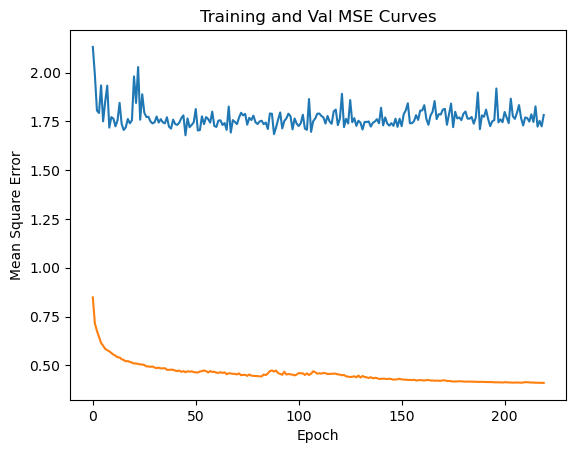

In [49]:
# Plot validation and training MSE curves.
y1 = hist6.history['val_mse']
y2 = hist6.history['mse']
x = range(len(hist6.history['val_mse']))
plt.plot(x,y1,y2)
plt.title("Training and Val MSE Curves")
plt.xlabel("Epoch")
plt.ylabel("Mean Square Error")

plt.show()

In [50]:
# Make predictions using current model.
predictions = pred_data(model=model_6,pre_data=train_data,post_data=val_data,scaler=scaler,pred_data_length=sample_length,
    cols=columns_to_predict,dataset_columns=val_data.columns)

predictions.head()

,1_AUTOMOTIVE_onpromotion,1_BABY CARE_onpromotion,1_BEAUTY_onpromotion,1_BEVERAGES_onpromotion,1_BOOKS_onpromotion,1_BREAD/BAKERY_onpromotion,1_CELEBRATION_onpromotion,1_CLEANING_onpromotion,1_DAIRY_onpromotion,1_DELI_onpromotion,...,54_MAGAZINES_sales,54_MEATS_sales,54_PERSONAL CARE_sales,54_PET SUPPLIES_sales,54_PLAYERS AND ELECTRONICS_sales,54_POULTRY_sales,54_PREPARED FOODS_sales,54_PRODUCE_sales,54_SCHOOL AND OFFICE SUPPLIES_sales,54_SEAFOOD_sales
date,,,,,,,,,,,,,,,,,,,,,
2017-06-28,0.0,0.0,1.0,26.0,0.0,6.0,0.0,43.0,23.0,1.0,...,0.641603,65.061541,114.989316,0.041412,1.861360,50.714241,77.803239,457.826006,0.127640,2.542304
2017-06-29,0.0,0.0,1.0,26.0,0.0,6.0,0.0,42.0,23.0,1.0,...,0.808935,46.751452,141.350409,0.052546,2.006609,49.510315,76.796760,526.524163,0.461110,2.885766
2017-06-30,0.0,0.0,1.0,30.0,0.0,9.0,0.0,48.0,23.0,53.0,...,0.696783,62.884893,129.309681,0.061367,2.005717,51.744993,78.631321,497.948682,0.222356,2.741883
2017-07-01,0.0,0.0,1.0,27.0,0.0,6.0,0.0,39.0,20.0,0.0,...,1.137695,52.447007,178.826447,0.030391,2.930657,58.931195,80.500142,590.743675,0.498075,2.429022
2017-07-02,0.0,0.0,1.0,25.0,0.0,6.0,0.0,30.0,19.0,2.0,...,1.523338,66.483097,306.235680,0.163010,4.530409,79.035977,123.500622,796.727456,5.240029,2.893999


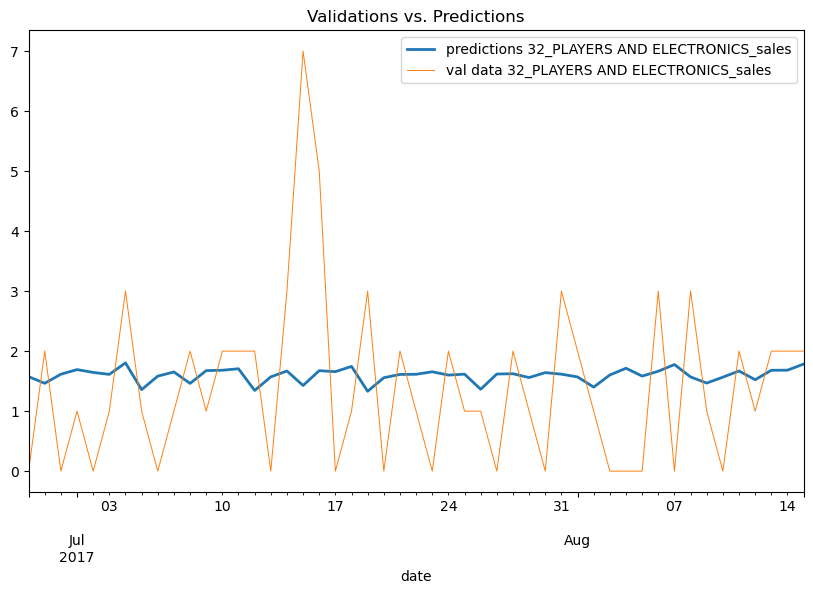

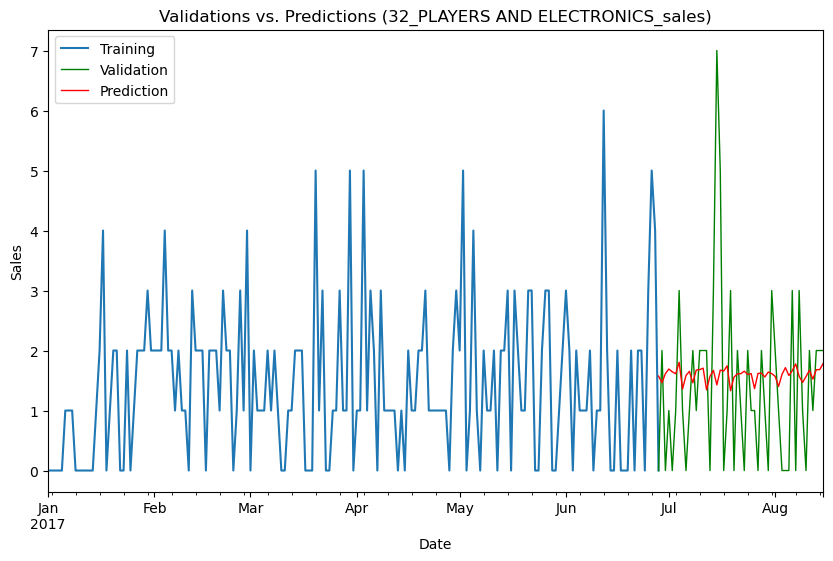

In [51]:
# Plot snapshot of performance.
ax = predictions[c].rename(f'predictions {c}').plot(figsize=(10,6), lw=2, title='Validations vs. Predictions', legend=True)
val_data[c].rename(f'val data {c}').plot(ax=ax, lw=0.7, legend=True)
plt.show()

# Plot performance against training data.
ax = train_data[[c]].loc['2017':].plot(figsize=(10,6), title=f'Validations vs. Predictions ({c})')
val_data[[c]].loc['2017':].plot(ax=ax, lw=1, color='g')
(predictions[[c]].loc['2017':]).plot(ax=ax, lw=1, color='r')
ax.legend(['Training','Validation','Prediction'])
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
plt.show()

__Discussion:__

As I was training the final model, I become disenchanged with RMSProp's choppy behavior and decided that I would submit each model's test predictions to kaggle.  First we will prepair the test data.

In [52]:
# Remind ourselves what the test data looks like.
test_df.head()

,id,store_nbr,family,onpromotion
date,,,,
2017-08-16,3000888,1,AUTOMOTIVE,0
2017-08-16,3000889,1,BABY CARE,0
2017-08-16,3000890,1,BEAUTY,2
2017-08-16,3000891,1,BEVERAGES,20
2017-08-16,3000892,1,BOOKS,0


In [53]:
# Pass through data augmentation helper function.
transformed_test_df, columns, columns_to_predict = augment_data(test_df,test_dataset=True,columns_to_predict=columns_to_predict,columns=columns,)
transformed_test_df.head()

,1_AUTOMOTIVE_onpromotion,1_BABY CARE_onpromotion,1_BEAUTY_onpromotion,1_BEVERAGES_onpromotion,1_BOOKS_onpromotion,1_BREAD/BAKERY_onpromotion,1_CELEBRATION_onpromotion,1_CLEANING_onpromotion,1_DAIRY_onpromotion,1_DELI_onpromotion,...,54_MAGAZINES_sales,54_MEATS_sales,54_PERSONAL CARE_sales,54_PET SUPPLIES_sales,54_PLAYERS AND ELECTRONICS_sales,54_POULTRY_sales,54_PREPARED FOODS_sales,54_PRODUCE_sales,54_SCHOOL AND OFFICE SUPPLIES_sales,54_SEAFOOD_sales
date,,,,,,,,,,,,,,,,,,,,,
2017-08-16,0,0,2,20,0,12,0,25,45,18,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
2017-08-17,0,0,1,17,0,7,0,7,13,7,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
2017-08-18,0,0,1,12,0,10,0,6,18,52,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
2017-08-19,0,0,1,11,0,9,0,11,20,6,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
2017-08-20,0,0,1,10,0,5,0,4,17,6,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1


__Discussion:__

A helper function that splits the sales columns away from the test data.

In [54]:
def no_sales(n):
    s = n.split('_')
    return f'{s[0]}_{s[1]}'

__Discussion:__

Perform test predictions with model 1, the light LSTM model.

In [57]:
# MAke test predictions.
test_predictions = pred_data(model=model_1,pre_data=transformed_df,post_data=transformed_test_df,scaler=scaler,
    pred_data_length=sample_length,cols=columns_to_predict,dataset_columns=val_data.columns)
test_predictions.head()

,1_AUTOMOTIVE_onpromotion,1_BABY CARE_onpromotion,1_BEAUTY_onpromotion,1_BEVERAGES_onpromotion,1_BOOKS_onpromotion,1_BREAD/BAKERY_onpromotion,1_CELEBRATION_onpromotion,1_CLEANING_onpromotion,1_DAIRY_onpromotion,1_DELI_onpromotion,...,54_MAGAZINES_sales,54_MEATS_sales,54_PERSONAL CARE_sales,54_PET SUPPLIES_sales,54_PLAYERS AND ELECTRONICS_sales,54_POULTRY_sales,54_PREPARED FOODS_sales,54_PRODUCE_sales,54_SCHOOL AND OFFICE SUPPLIES_sales,54_SEAFOOD_sales
date,,,,,,,,,,,,,,,,,,,,,
2017-08-16,0.0,0.0,2.0,20.0,0.0,12.0,0.0,25.0,45.0,18.0,...,0.720269,52.074056,167.722192,0.205065,4.315137,61.025172,69.295516,548.665679,-1.562113,1.550769
2017-08-17,0.0,0.0,1.0,17.0,0.0,7.0,0.0,7.0,13.0,7.0,...,0.686490,55.220129,183.614230,0.227162,4.199301,60.277454,71.865389,581.246108,-0.780875,1.651255
2017-08-18,0.0,0.0,1.0,12.0,0.0,10.0,0.0,6.0,18.0,52.0,...,0.699230,56.907117,183.753524,0.264955,4.269345,60.229892,73.492547,547.736258,-0.504746,1.629091
2017-08-19,0.0,0.0,1.0,11.0,0.0,9.0,0.0,11.0,20.0,6.0,...,0.735329,58.491293,193.601576,0.290874,4.456081,59.732176,73.652297,539.612282,-0.101897,1.637913
2017-08-20,0.0,0.0,1.0,10.0,0.0,5.0,0.0,4.0,17.0,6.0,...,0.705771,59.755980,197.249335,0.277073,4.317625,60.093396,74.363246,506.938796,-0.008204,1.792063


In [58]:
# https://www.kaggle.com/code/sevendev/sales-forecasting-with-lstm

df1 = test_predictions[columns_to_predict]
df1.columns = list(map(no_sales, df1.columns))

scols = df1.columns.str.split('_', expand=True)
scols = list(map(lambda c1: (int(c1[0]), c1[1]), scols.tolist()))
multi_index = pd.MultiIndex.from_tuples(scols, names=['store_nbr', 'family'])
df1.columns = multi_index

df1 = df1.stack(level='store_nbr').stack(level='family')
df1 = df1.reset_index().rename(columns={0: 'sales'})

df1 = df1.set_index('date', drop=True)
df1 = pd.merge(test_df, df1, on=['date', 'store_nbr', 'family'], how='left')
df1 = df1[['id', 'sales']]
df1 = df1.reset_index(drop=True)

df1.to_csv('submission_1.csv', encoding='utf-8', index=False)

__Discussion:__

Perform test predictions with model 2, the heavy LSTM model.

In [59]:
test_predictions = pred_data(model=model_2,pre_data=transformed_df,post_data=transformed_test_df,scaler=scaler,
    pred_data_length=sample_length,cols=columns_to_predict,dataset_columns=val_data.columns)
test_predictions.head()

,1_AUTOMOTIVE_onpromotion,1_BABY CARE_onpromotion,1_BEAUTY_onpromotion,1_BEVERAGES_onpromotion,1_BOOKS_onpromotion,1_BREAD/BAKERY_onpromotion,1_CELEBRATION_onpromotion,1_CLEANING_onpromotion,1_DAIRY_onpromotion,1_DELI_onpromotion,...,54_MAGAZINES_sales,54_MEATS_sales,54_PERSONAL CARE_sales,54_PET SUPPLIES_sales,54_PLAYERS AND ELECTRONICS_sales,54_POULTRY_sales,54_PREPARED FOODS_sales,54_PRODUCE_sales,54_SCHOOL AND OFFICE SUPPLIES_sales,54_SEAFOOD_sales
date,,,,,,,,,,,,,,,,,,,,,
2017-08-16,0.0,0.0,2.0,20.0,0.0,12.0,0.0,25.0,45.0,18.0,...,0.494089,59.711528,184.613717,0.079883,3.390857,65.188402,89.667560,657.508731,1.160730,1.817012
2017-08-17,0.0,0.0,1.0,17.0,0.0,7.0,0.0,7.0,13.0,7.0,...,0.256479,59.901277,171.067374,0.110216,3.270225,63.679893,87.881837,648.653560,0.459375,2.063003
2017-08-18,0.0,0.0,1.0,12.0,0.0,10.0,0.0,6.0,18.0,52.0,...,0.360942,59.248843,179.459806,0.097995,3.234815,66.009925,90.421728,652.049860,0.431619,1.806477
2017-08-19,0.0,0.0,1.0,11.0,0.0,9.0,0.0,11.0,20.0,6.0,...,0.560608,58.542622,192.604423,0.047464,3.492922,69.677779,90.876843,708.642460,0.330241,1.383959
2017-08-20,0.0,0.0,1.0,10.0,0.0,5.0,0.0,4.0,17.0,6.0,...,0.709750,61.763180,221.529366,0.050480,3.755097,73.490637,99.719649,748.946381,0.237968,1.192322


In [60]:
# https://www.kaggle.com/code/sevendev/sales-forecasting-with-lstm

df1 = test_predictions[columns_to_predict]
df1.columns = list(map(no_sales, df1.columns))

scols = df1.columns.str.split('_', expand=True)
scols = list(map(lambda c1: (int(c1[0]), c1[1]), scols.tolist()))
multi_index = pd.MultiIndex.from_tuples(scols, names=['store_nbr', 'family'])
df1.columns = multi_index

df1 = df1.stack(level='store_nbr').stack(level='family')
df1 = df1.reset_index().rename(columns={0: 'sales'})

df1 = df1.set_index('date', drop=True)
df1 = pd.merge(test_df, df1, on=['date', 'store_nbr', 'family'], how='left')
df1 = df1[['id', 'sales']]
df1 = df1.reset_index(drop=True)

df1.to_csv('submission_2.csv', encoding='utf-8', index=False)

__Discussion:__

Perform test predictions with model 3, the tall, but light LSTM model.

In [61]:
test_predictions = pred_data(model=model_3,pre_data=transformed_df,post_data=transformed_test_df,scaler=scaler,
    pred_data_length=sample_length,cols=columns_to_predict,dataset_columns=val_data.columns)
test_predictions.head()

,1_AUTOMOTIVE_onpromotion,1_BABY CARE_onpromotion,1_BEAUTY_onpromotion,1_BEVERAGES_onpromotion,1_BOOKS_onpromotion,1_BREAD/BAKERY_onpromotion,1_CELEBRATION_onpromotion,1_CLEANING_onpromotion,1_DAIRY_onpromotion,1_DELI_onpromotion,...,54_MAGAZINES_sales,54_MEATS_sales,54_PERSONAL CARE_sales,54_PET SUPPLIES_sales,54_PLAYERS AND ELECTRONICS_sales,54_POULTRY_sales,54_PREPARED FOODS_sales,54_PRODUCE_sales,54_SCHOOL AND OFFICE SUPPLIES_sales,54_SEAFOOD_sales
date,,,,,,,,,,,,,,,,,,,,,
2017-08-16,0.0,0.0,2.0,20.0,0.0,12.0,0.0,25.0,45.0,18.0,...,0.995952,63.281710,205.593677,0.232530,3.844203,59.558167,100.289334,746.604018,0.542081,2.931145
2017-08-17,0.0,0.0,1.0,17.0,0.0,7.0,0.0,7.0,13.0,7.0,...,0.792358,59.066721,172.018597,0.169384,2.860626,55.052192,92.666959,635.176146,0.164329,2.813890
2017-08-18,0.0,0.0,1.0,12.0,0.0,10.0,0.0,6.0,18.0,52.0,...,0.873796,58.139759,160.273355,0.147404,2.761186,57.254617,88.489754,585.558023,-0.554441,2.632255
2017-08-19,0.0,0.0,1.0,11.0,0.0,9.0,0.0,11.0,20.0,6.0,...,1.079426,60.414352,177.634987,0.184196,3.510614,66.804026,89.391989,635.077438,-1.213933,2.394626
2017-08-20,0.0,0.0,1.0,10.0,0.0,5.0,0.0,4.0,17.0,6.0,...,1.178649,64.468711,217.478728,0.208023,4.209840,77.264879,95.964505,705.377664,-1.391340,2.450509


In [62]:
# https://www.kaggle.com/code/sevendev/sales-forecasting-with-lstm

df1 = test_predictions[columns_to_predict]
df1.columns = list(map(no_sales, df1.columns))

scols = df1.columns.str.split('_', expand=True)
scols = list(map(lambda c1: (int(c1[0]), c1[1]), scols.tolist()))
multi_index = pd.MultiIndex.from_tuples(scols, names=['store_nbr', 'family'])
df1.columns = multi_index

df1 = df1.stack(level='store_nbr').stack(level='family')
df1 = df1.reset_index().rename(columns={0: 'sales'})

df1 = df1.set_index('date', drop=True)
df1 = pd.merge(test_df, df1, on=['date', 'store_nbr', 'family'], how='left')
df1 = df1[['id', 'sales']]
df1 = df1.reset_index(drop=True)

df1.to_csv('submission_3.csv', encoding='utf-8', index=False)

__Discussion:__

Perform test predictions with model 4, the GRU model.

In [67]:
test_predictions = pred_data(model=model_4,pre_data=transformed_df,post_data=transformed_test_df,scaler=scaler,
    pred_data_length=sample_length,cols=columns_to_predict,dataset_columns=val_data.columns)
test_predictions.head()

,1_AUTOMOTIVE_onpromotion,1_BABY CARE_onpromotion,1_BEAUTY_onpromotion,1_BEVERAGES_onpromotion,1_BOOKS_onpromotion,1_BREAD/BAKERY_onpromotion,1_CELEBRATION_onpromotion,1_CLEANING_onpromotion,1_DAIRY_onpromotion,1_DELI_onpromotion,...,54_MAGAZINES_sales,54_MEATS_sales,54_PERSONAL CARE_sales,54_PET SUPPLIES_sales,54_PLAYERS AND ELECTRONICS_sales,54_POULTRY_sales,54_PREPARED FOODS_sales,54_PRODUCE_sales,54_SCHOOL AND OFFICE SUPPLIES_sales,54_SEAFOOD_sales
date,,,,,,,,,,,,,,,,,,,,,
2017-08-16,0.0,0.0,2.0,20.0,0.0,12.0,0.0,25.0,45.0,18.0,...,1.283900,57.654627,246.772549,0.222396,5.605171,95.158891,94.276778,822.366826,2.497640,2.792290
2017-08-17,0.0,0.0,1.0,17.0,0.0,7.0,0.0,7.0,13.0,7.0,...,1.275740,63.764136,279.361019,0.199184,5.508343,102.501563,104.248646,820.624021,2.541810,2.872201
2017-08-18,0.0,0.0,1.0,12.0,0.0,10.0,0.0,6.0,18.0,52.0,...,1.400372,52.525507,241.507646,0.135795,5.122464,72.726160,84.762055,674.162217,4.979309,2.940164
2017-08-19,0.0,0.0,1.0,11.0,0.0,9.0,0.0,11.0,20.0,6.0,...,1.632552,49.058679,227.045491,0.123770,5.607500,64.420093,73.640770,620.434004,6.030289,2.872608
2017-08-20,0.0,0.0,1.0,10.0,0.0,5.0,0.0,4.0,17.0,6.0,...,1.954401,56.380579,268.161667,0.150986,6.845722,75.428650,86.875308,766.229075,7.920178,2.918507


In [68]:
# https://www.kaggle.com/code/sevendev/sales-forecasting-with-lstm

df1 = test_predictions[columns_to_predict]
df1.columns = list(map(no_sales, df1.columns))

scols = df1.columns.str.split('_', expand=True)
scols = list(map(lambda c1: (int(c1[0]), c1[1]), scols.tolist()))
multi_index = pd.MultiIndex.from_tuples(scols, names=['store_nbr', 'family'])
df1.columns = multi_index

df1 = df1.stack(level='store_nbr').stack(level='family')
df1 = df1.reset_index().rename(columns={0: 'sales'})

df1 = df1.set_index('date', drop=True)
df1 = pd.merge(test_df, df1, on=['date', 'store_nbr', 'family'], how='left')
df1 = df1[['id', 'sales']]
df1 = df1.reset_index(drop=True)

df1.to_csv('submission_4.csv', encoding='utf-8', index=False)

__Discussion:__

Model 5 was a dummy model used for the hyper parameter tuning section. Now perform test predictions with model 6, the optimized GRU model.

In [65]:
test_predictions = pred_data(model=model_6,pre_data=transformed_df,post_data=transformed_test_df,scaler=scaler,
    pred_data_length=sample_length,cols=columns_to_predict,dataset_columns=val_data.columns)
test_predictions.head()

,1_AUTOMOTIVE_onpromotion,1_BABY CARE_onpromotion,1_BEAUTY_onpromotion,1_BEVERAGES_onpromotion,1_BOOKS_onpromotion,1_BREAD/BAKERY_onpromotion,1_CELEBRATION_onpromotion,1_CLEANING_onpromotion,1_DAIRY_onpromotion,1_DELI_onpromotion,...,54_MAGAZINES_sales,54_MEATS_sales,54_PERSONAL CARE_sales,54_PET SUPPLIES_sales,54_PLAYERS AND ELECTRONICS_sales,54_POULTRY_sales,54_PREPARED FOODS_sales,54_PRODUCE_sales,54_SCHOOL AND OFFICE SUPPLIES_sales,54_SEAFOOD_sales
date,,,,,,,,,,,,,,,,,,,,,
2017-08-16,0.0,0.0,2.0,20.0,0.0,12.0,0.0,25.0,45.0,18.0,...,1.283900,57.654627,246.772549,0.222396,5.605171,95.158891,94.276778,822.366826,2.497640,2.792290
2017-08-17,0.0,0.0,1.0,17.0,0.0,7.0,0.0,7.0,13.0,7.0,...,1.275740,63.764136,279.361019,0.199184,5.508343,102.501563,104.248646,820.624021,2.541810,2.872201
2017-08-18,0.0,0.0,1.0,12.0,0.0,10.0,0.0,6.0,18.0,52.0,...,1.400372,52.525507,241.507646,0.135795,5.122464,72.726160,84.762055,674.162217,4.979309,2.940164
2017-08-19,0.0,0.0,1.0,11.0,0.0,9.0,0.0,11.0,20.0,6.0,...,1.632552,49.058679,227.045491,0.123770,5.607500,64.420093,73.640770,620.434004,6.030289,2.872608
2017-08-20,0.0,0.0,1.0,10.0,0.0,5.0,0.0,4.0,17.0,6.0,...,1.954401,56.380579,268.161667,0.150986,6.845722,75.428650,86.875308,766.229075,7.920178,2.918507


In [66]:
# https://www.kaggle.com/code/sevendev/sales-forecasting-with-lstm

df1 = test_predictions[columns_to_predict]
df1.columns = list(map(no_sales, df1.columns))

scols = df1.columns.str.split('_', expand=True)
scols = list(map(lambda c1: (int(c1[0]), c1[1]), scols.tolist()))
multi_index = pd.MultiIndex.from_tuples(scols, names=['store_nbr', 'family'])
df1.columns = multi_index

df1 = df1.stack(level='store_nbr').stack(level='family')
df1 = df1.reset_index().rename(columns={0: 'sales'})

df1 = df1.set_index('date', drop=True)
df1 = pd.merge(test_df, df1, on=['date', 'store_nbr', 'family'], how='left')
df1 = df1[['id', 'sales']]
df1 = df1.reset_index(drop=True)

df1.to_csv('submission_6.csv', encoding='utf-8', index=False)

__Discussion:__

As for our final results, I was shocked to discover that the GRU model performed THE WORST.  The heavy LSTM performed the best, despite having a choppier validation MSE curve.  It appears that making a heavier and heavier LSTM model is actually the way to go for this problem.  I believe in the future I'll change my workflow to start with very large models and then determine how to improve them prior to attempting to make them lighter.  See Kaggle submission scores below.

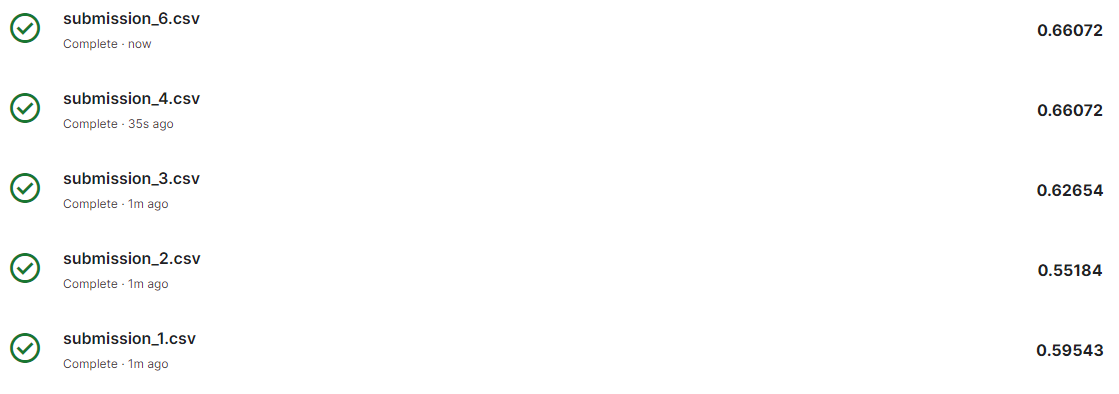

__References:__

1) Tensorflow.  An end-to-end platform for machine learning. https://www.tensorflow.org/
2) Keras.  Simple. Flexible. Powerful. https://keras.io/
3) Kaggle.  intro-to-recurrent-neural-networks-lstm-gru. thebrownviking20. https://www.kaggle.com/code/thebrownviking20/intro-to-recurrent-neural-networks-lstm-gru
4) Kaggle.  sales-forecasting-with-lstm.  sevendev.  https://www.kaggle.com/code/sevendev/sales-forecasting-with-lstm